## Does not make sense

Cannot be finetuned with all 4 losses. The term 1 and term 4 are contradictory.

In [54]:
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [55]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda:5')
else:
    device = torch.device('cpu')
    
print(device)
device = torch.device('cpu')

cpu


In [56]:
# the deep neural network
class MLP(torch.nn.Module):
    def __init__(self, layers, activation="relu", init="xavier"):
        super(MLP, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        if activation == "relu":
            self.activation = torch.nn.ReLU()
        elif activation == "tanh":
            self.activation = torch.nn.Tanh()
        elif activation == "gelu":
            self.activation = torch.nn.GELU()
        else:
            raise ValueError("Unspecified activation type")
        
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)

        if init=="xavier":
            self.xavier_init_weights()
        elif init=="kaiming":
            self.kaiming_init_weights()
    
    def xavier_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Xavier Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.xavier_uniform_(m.weight)
                    m.bias.data.fill_(0.0)

    def kaiming_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Kaiming Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.kaiming_uniform_(m.weight)
                    m.bias.data.fill_(0.0)
                        
    def forward(self, x):
        out = self.layers(x)
        return out
    
class DataGenerator(torch.utils.data.Dataset):
    def __init__(self, X):
        self.X = X
        
    def __getitem__(self, index):
        return self.X[index]
    
    def __len__(self):
        return len(self.X)

In [57]:
data_df = pd.read_csv("all_data_lake_modeling_in_time_wHeat.csv")
time = data_df['time']
data_df = data_df.drop(columns=['time'])
data_df
display(data_df.head)

<bound method NDFrame.head of         depth  AirTemp_degC  Longwave_Wm-2  Latent_Wm-2  Sensible_Wm-2  \
0           1     10.715021     695.937161   -56.268384     -23.291619   
1           2     10.715021     695.937161   -56.268384     -23.291619   
2           3     10.715021     695.937161   -56.268384     -23.291619   
3           4     10.715021     695.937161   -56.268384     -23.291619   
4           5     10.715021     695.937161   -56.268384     -23.291619   
...       ...           ...            ...          ...            ...   
141570     21     21.695001     832.055902   -93.493728     -12.091248   
141571     22     21.695001     832.055902   -93.493728     -12.091248   
141572     23     21.695001     832.055902   -93.493728     -12.091248   
141573     24     21.695001     832.055902   -93.493728     -12.091248   
141574     25     21.695001     832.055902   -93.493728     -12.091248   

        Shortwave_Wm-2  lightExtinct_m-1  ShearVelocity_mS-1  \
0                

In [58]:
training_frac = 0.60
depth_steps = 25
number_days = len(data_df)//depth_steps
n_obs = int(number_days*training_frac)*depth_steps
print(f"Number of days total: {number_days}")
print(f"Number of training points: {n_obs}")

Number of days total: 5663
Number of training points: 84925


# Normalizing Data

In [59]:
data = data_df.values

train_data = data[:n_obs]
test_data = data[n_obs:]

train_time = time[:n_obs]
test_time = time[n_obs:]

#performing normalization on all the columns
scaler = StandardScaler()
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [60]:
m0_output_column_ix = [data_df.columns.get_loc(column) for column in ['temp_heat00']]

# Loading Models

In [61]:
m0_input_columns = ['depth', 'AirTemp_degC', 'Longwave_Wm-2', 'Latent_Wm-2', 'Sensible_Wm-2', 'Shortwave_Wm-2',
                'lightExtinct_m-1','Area_m2', 
                 'day_of_year', 'time_of_day', 'input_temp']
m0_output_columns = ['temp_heat00']

m0_input_column_ix = [data_df.columns.get_loc(column) for column in m0_input_columns]
m0_output_column_ix = [data_df.columns.get_loc(column) for column in m0_output_columns]

m0_PATH =  f"./saved_models/heating_model_time.pth"
m0_layers = [len(m0_input_columns), 32, 32, len(m0_output_columns)]

heating_model = MLP(m0_layers, activation="gelu")
m0_checkpoint = torch.load(m0_PATH, map_location=torch.device('cpu'))
heating_model.load_state_dict(m0_checkpoint)
heating_model = heating_model.to(device)

Initializing Network with Xavier Initialization..


## Heat Diffusion Model

In [62]:
m1_input_columns = ['depth', 'AirTemp_degC', 'Longwave_Wm-2', 'Latent_Wm-2', 'Sensible_Wm-2', 'Shortwave_Wm-2',
                'lightExtinct_m-1', 'ShearVelocity_mS-1', 'ShearStress_Nm-2', 'Area_m2', 
                 'buoyancy', 'day_of_year', 'time_of_day', 'diffusivity', 'temp_heat00']
m1_output_columns = ['temp_diff01']

m1_input_column_ix = [data_df.columns.get_loc(column) for column in m1_input_columns]
m1_output_column_ix = [data_df.columns.get_loc(column) for column in m1_output_columns]

m1_PATH = f"./saved_models/heat_diffusion_model_time.pth"
m1_layers = [len(m1_input_columns), 32, 32, len(m1_output_columns)]

heat_diff_model = MLP(m1_layers, activation="gelu")
m1_checkpoint = torch.load(m1_PATH, map_location=torch.device('cpu'))
heat_diff_model.load_state_dict(m1_checkpoint)
heat_diff_model = heat_diff_model.to(device)

Initializing Network with Xavier Initialization..


## Mixing Model

In [63]:
m2_input_columns = ['depth', 'ShearVelocity_mS-1', 'ShearStress_Nm-2', 'day_of_year', 'time_of_day', 'temp_diff01']
m2_output_columns = ['temp_mix02']

m2_input_column_ix = [data_df.columns.get_loc(column) for column in m2_input_columns]
m2_output_column_ix = [data_df.columns.get_loc(column) for column in m2_output_columns]

m2_PATH = f"./saved_models/mixing_model_time.pth"
m2_layers = [len(m2_input_columns), 32, 32, len(m2_output_columns)]

mixing_model = MLP(m2_layers, activation="gelu")
m2_checkpoint = torch.load(m2_PATH, map_location=torch.device('cpu'))
mixing_model.load_state_dict(m2_checkpoint)
mixing_model = mixing_model.to(device)

Initializing Network with Xavier Initialization..


# Convection Model

In [64]:
m3_input_columns = ['depth', 'day_of_year', 'time_of_day', 'temp_mix02']
m3_output_columns = ['temp_conv03']

m3_input_column_ix = [data_df.columns.get_loc(column) for column in m3_input_columns]
m3_output_column_ix = [data_df.columns.get_loc(column) for column in m3_output_columns]

m3_PATH = f"./saved_models/convection_model_time.pth"
m3_layers = [len(m3_input_columns), 32, 32, len(m3_output_columns)]

convection_model = MLP(m3_layers, activation="gelu")
m3_checkpoint = torch.load(m3_PATH, map_location=torch.device('cpu'))
convection_model.load_state_dict(m3_checkpoint)
convection_model = convection_model.to(device)

Initializing Network with Xavier Initialization..


# Ice Model

In [65]:
m4_input_columns = ['depth', 'day_of_year', 'time_of_day', 'temp_conv03']
m4_output_columns = ['temp_total04']

m4_input_column_ix = [data_df.columns.get_loc(column) for column in m4_input_columns]
m4_output_column_ix = [data_df.columns.get_loc(column) for column in m4_output_columns]

m4_PATH = f"./saved_models/ice_model_time.pth"
m4_layers = [len(m4_input_columns), 32, 32, len(m4_output_columns)]

ice_model = MLP(m4_layers, activation="gelu")
m4_checkpoint = torch.load(m4_PATH, map_location=torch.device('cpu'))
ice_model.load_state_dict(m4_checkpoint)
ice_model = ice_model.to(device)

Initializing Network with Xavier Initialization..


In [66]:
obs_temp_columns = ['obs_temp']

obs_temp_columns_ix = [data_df.columns.get_loc(column) for column in obs_temp_columns]

In [67]:
# depth_steps = 24
# train_data = np.reshape(train_data, (train_data.shape[0]//depth_steps, depth_steps, train_data.shape[1]))
# test_data = np.reshape(test_data, (test_data.shape[0]//depth_steps, depth_steps, test_data.shape[1]))

In [68]:
#keeping track of the mean and standard deviations
train_mean = scaler.mean_
train_std = scaler.scale_

In [69]:
# Create data set
batch_size = 1000

assert batch_size % 25 ==0, "Batchsize has to be multiple of 25" 

train_dataset = DataGenerator(train_data)
test_dataset = DataGenerator(test_data)
# train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
# test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False)

In [70]:
print(train_data.shape)
print(test_data.shape)

(84925, 22)
(56650, 22)


In [71]:
def rmse(true, pred):
    return (((true-pred)**2).mean()**0.5).detach().cpu().numpy()

def l2_error(true, pred):
    return np.linalg.norm(pred.detach().cpu().numpy() - true.detach().cpu().numpy()) / np.linalg.norm(true.detach().cpu().numpy()) 

In [72]:
#keeping track of the mean and standard deviations

input_mean, input_std = train_mean[m1_input_column_ix], train_std[m1_input_column_ix]
output_mean, output_std = train_mean[m1_output_column_ix], train_std[m1_output_column_ix]

mean_diff = torch.tensor(input_mean[m1_input_column_ix[13]]).to(device)
std_diff = torch.tensor(input_std[m1_input_column_ix[13]]).to(device)

mean_temp = torch.tensor(input_mean[m1_input_column_ix[14]]).to(device)
std_temp = torch.tensor(input_std[m1_input_column_ix[14]]).to(device)

mean_out = torch.tensor(output_mean).to(device)
std_out = torch.tensor(output_std).to(device)
    
def implicit_diffusion(diff, temp, dt=3600, dx=1, depth_steps=25):
    # de-normalise data
    diff = diff * std_diff + mean_diff
    diff = diff.view(-1, depth_steps)
    
    # INPUT DATA FROM PREVIOUS MODULE
    t = temp * std_temp + mean_temp # temperature profile from previous module output
    t = t.view(-1, depth_steps)
    
    # IMPLEMENTATION OF CRANK-NICHOLSON SCHEME
#     len_t = t.shape[1]
    y = torch.zeros((t.shape[0], depth_steps, depth_steps), dtype=torch.float64).to(device)

    alpha = (dt/dx**2) * diff

    az = - alpha # subdiagonal
    bz = 2 * (1 + alpha) # diagonal
    cz = - alpha # superdiagonal
    
    bz[:, 0] = 1
    az[:, depth_steps-2] = 0
    bz[:, depth_steps-1] = 1
    cz[:, 0] = 0
    
    az = az[:,1:]
    cz = cz[:,:-1]

    y = torch.diag_embed(bz, offset=0)+torch.diag_embed(az,offset=-1)+torch.diag_embed(cz,offset=1) #slightly efficient way of computing the diagonal matrices
    y[:, depth_steps-1, depth_steps-1] = 1
    
    mn = torch.zeros_like(t)  
    mn[:, 0] = t[:, 0]
    mn[:,depth_steps-1] = t[:, depth_steps-1]
    
    mn[:, 1:depth_steps-1] = alpha[:, 1:depth_steps-1]*t[:, :depth_steps-2] + 2 * (1 - alpha[:,1:depth_steps-1])*t[:,1:depth_steps-1] + alpha[:,1:depth_steps-1]*t[:,1:depth_steps-1] #is be same as the loop
    
    # DERIVED TEMPERATURE OUTPUT FOR NEXT MODULE
    proj = torch.linalg.solve(y, mn)

    mean, std, var = torch.mean(proj), torch.std(proj), torch.var(proj)
    proj = (proj-mean_out)/std_out

    proj = proj.to(torch.float32)
    proj = proj.view(-1, 1)
    return proj

In [73]:
def compute_metrics(model, loader, input_columns, output_columns, train_mean, train_std):
    model.eval()
    y_ = []
    pred_ = []
    mean = torch.tensor(train_mean[output_columns]).to(device)
    std = torch.tensor(train_std[output_columns]).to(device)
    
    for x in iter(loader):
        inputs, target = x[:, input_columns].to(device).float(), x[:, output_columns].to(device).float()
        pred = model(inputs)
        target = target * std + mean
        pred = pred * std + mean
        y_.append(target)
        pred_.append(pred)
    y_ = torch.cat(y_, dim=0) 
    pred_ = torch.cat(pred_, dim=0)
    
    if y_.shape[1]==2:
        rmse_temp = rmse(y_[:,1], pred_[:,1])
        l2_error_temp = l2_error(y_[:,1], pred_[:,1])
    else:
        rmse_temp = rmse(y_[:,0], pred_[:,0])
        l2_error_temp = l2_error(y_[:,0], pred_[:,0])
        
    return rmse_temp, l2_error_temp

In [74]:
print(m1_input_column_ix)
print(m1_input_column_ix[:-1])
print(m1_input_column_ix[:-2])
print(m1_input_column_ix[14])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 16, 17, 13, 14]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 16, 17, 13]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 16, 17]
14


In [75]:
def get_rollout_predictions(heating_model, heat_diff_model, mixing_model, convection_model, ice_model, loader, plot = True):    
    heating_model.eval()
    heat_diff_model.eval()
    mixing_model.eval()
    convection_model.eval()
    ice_model.eval()

    mean = torch.tensor(train_mean[m4_output_column_ix]).float().to(device)
    std = torch.tensor(train_std[m4_output_column_ix]).float().to(device)

    m1_mean = torch.tensor(train_mean[m1_input_column_ix[-1]]).float().to(device)
    m1_std = torch.tensor(train_std[m1_input_column_ix[-1]]).float().to(device)

#     depthwise_y_pred = []
#     depthwise_y_true = []
    y_ = []
    y_obs_ = []
    pred_ = []
        
    rmse_models = np.zeros((len(loader), 5))
    for ix, x in enumerate(iter(loader)):
        x = x.to(device).float()
        
        m0_input = x[:, m0_input_column_ix]
            
        #model 0
        m0_pred = heating_model(m0_input) #predicts diff and temp
            
        if plot:
            m0_y_true = x[:, m0_output_column_ix[0]] * torch.tensor(train_std[m0_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m0_output_column_ix[0]]).to(device)
            m0_y_pred = m0_pred * torch.tensor(train_std[m0_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m0_output_column_ix[0]]).to(device)
#             print(m1_y_true.shape, m1_y_pred.shape)
#             print("True",m1_y_true)
#             print("Pred",m1_y_pred)
            rmse_models[ix, 0] = rmse(m0_y_true.squeeze(), m0_y_pred.squeeze())
#             print(x[:, m1_output_column_ix[1]])
#             print(m1_pred_temp)
#             print(criterion(m1_pred_temp, x[:, m1_output_column_ix[1]]))
            print("RMSE of after m0", rmse(m0_y_true.flatten(), m0_y_pred.flatten()))

        #model 2
        m1_input = torch.cat([x[:, m1_input_column_ix[:-1]], m0_pred], dim=-1)
        #m1_input = x[:, m1_input_column_ix]
            
        #model 1
        # m1_pred = heat_diff_model(m1_input) #predicts diff and temp
        
        temp_input = m0_y_pred = m0_pred * torch.tensor(train_std[m0_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m0_output_column_ix[0]]).to(device)
       # print(temp_input)
        
        proj = heat_diff_model(m1_input)
        
        print(proj)
        
        pred = implicit_diffusion(proj, m0_pred)
        
        m1_pred = pred.to(dtype=torch.float32)
        
        print(m1_pred)
        
        #print(m1_pred)
        
        if plot:
            m1_y_true = x[:, m1_output_column_ix[0]] * torch.tensor(train_std[m1_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m1_output_column_ix[0]]).to(device)
            m1_y_pred = m1_pred * torch.tensor(train_std[m1_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m1_output_column_ix[0]]).to(device)
#             print(m1_y_true.shape, m1_y_pred.shape)
#             print("True",m1_y_true)
#             print("Pred",m1_y_pred)
            rmse_models[ix, 1] = rmse(m1_y_true.squeeze(), m1_y_pred.squeeze())
#             print(x[:, m1_output_column_ix[1]])
#             print(m1_pred_temp)
#             print(criterion(m1_pred_temp, x[:, m1_output_column_ix[1]]))
            print("RMSE of after m1", rmse(m1_y_true.flatten(), m1_y_pred.flatten()))

        #model 2
        m2_input = torch.cat([x[:, m2_input_column_ix[:-1]], m1_pred], dim=-1)
        m2_pred = mixing_model(m2_input)
            
        if plot:
            m2_y_true = x[:, m2_output_column_ix] * torch.tensor(train_std[m2_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m2_output_column_ix[0]]).to(device)
            m2_y_pred = m2_pred * torch.tensor(train_std[m2_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m2_output_column_ix[0]]).to(device)
            rmse_models[ix, 2] = rmse(m2_y_true.squeeze(), m2_y_pred.squeeze())
            print("RMSE of after m2", rmse(m2_y_true.flatten(), m2_y_pred.flatten()))

        #model 3
        m3_input = torch.cat([x[:, m3_input_column_ix[:-1]], m2_pred], dim=-1)
        m3_pred = convection_model(m3_input)
            
        if plot:
            m3_y_true = x[:, m3_output_column_ix] * torch.tensor(train_std[m3_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m3_output_column_ix[0]]).to(device)
            m3_y_pred = m3_pred * torch.tensor(train_std[m3_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m3_output_column_ix[0]]).to(device)
            rmse_models[ix, 3] = rmse(m3_y_true.squeeze(), m3_y_pred.squeeze())
            print("RMSE of after m3", rmse(m3_y_true.flatten(), m3_y_pred.flatten()))

        #model 4
        m4_input = torch.cat([x[:, m4_input_column_ix[:-1]], m3_pred], dim=-1)
        m4_pred = ice_model(m4_input)
            
        if plot:
            m4_y_true = x[:, m4_output_column_ix] * std + mean
            m4_y_pred = m4_pred * std + mean
            rmse_models[ix, 4] = rmse(m4_y_true.squeeze(), m4_y_pred.squeeze())
            print("RMSE of after m4", rmse(m4_y_true.flatten(), m4_y_pred.flatten()))

        y_true = x[:, m4_output_column_ix] * std + mean
        y_obs = x[:, obs_temp_columns_ix] * train_std[obs_temp_columns_ix[0]] + train_mean[obs_temp_columns_ix[0]]
        pred = m4_pred * std + mean
        
        y_.append(y_true)
        y_obs_.append(y_obs)
        pred_.append(pred)

    y_ = torch.cat(y_, dim=0)
    y_obs_ = torch.cat(y_obs_, dim=0)
    pred_ = torch.cat(pred_, dim=0) 
    
    #if plot:   
     #        rmse_models = rmse_models.mean(axis=0)
     #        plt.figure(figsize=(12,8))
     #        plt.plot(rmse_models[:, 0], label="RMSE after Heating Model")
     #        plt.plot(rmse_models[:, 1], label="RMSE after Heat-Diffusion Model")
     #        plt.plot(rmse_models[:, 2], label="RMSE after Mixing Model")
     #        plt.plot(rmse_models[:, 3], label="RMSE after Convection Model")
     #        plt.plot(rmse_models[:, 4], label="RMSE after Ice Model")
     #        plt.legend(loc="upper left", fontsize=12)
     #        plt.xlabel("Depth", fontsize=12)
     #        plt.ylabel("RMSE", fontsize=12)
     #        plt.grid("on", alpha=0.5)
     #        plt.show()
    
    return pred_, y_, y_obs_, rmse_models


In [76]:
def plot_output(y_pred, y_true, depth_steps, time_label, figsize=(20,10)):
    time_label = np.array([time[:10] for time in time_label])
    time_label = time_label[::depth_steps]
    
    y_pred = y_pred.flatten().detach().cpu().numpy()
    y_true = y_true.flatten().detach().cpu().numpy()
    
    y_true = np.reshape(y_true, (y_true.shape[0]//depth_steps, depth_steps))
    y_pred = np.reshape(y_pred, (y_pred.shape[0]//depth_steps, depth_steps))
    
    N_pts = 6 # number of points to display on the x-label
    
    fig, ax = plt.subplots(3, 1, figsize=figsize)
    sns.heatmap(y_true.T, ax=ax[0], cmap='seismic', vmin=0., vmax=35.)
    ax[0].set_ylabel("Depth", fontsize=15)
    ax[0].set_xlabel("Time", fontsize=15)
    
    xticks_ix = np.array(ax[0].get_xticks()).astype(int)
    time_label = time_label[xticks_ix]
    nelement = len(time_label)//N_pts
    time_label = time_label[::nelement]
    ax[0].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[0].set_xticklabels(time_label, rotation=0)   
#     ax[0].xaxis.set_major_locator(plt.MultipleLocator(100))
    ax[0].collections[0].colorbar.set_label("Actual Temperature")
    
    sns.heatmap(y_pred.T, ax=ax[1], cmap='seismic', vmin=0., vmax=35.)
    ax[1].set_ylabel("Depth", fontsize=15)
    ax[1].set_xlabel("Time", fontsize=15)
    ax[1].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[1].set_xticklabels(time_label, rotation=0)
    ax[1].collections[0].colorbar.set_label("Predicted Temperature")
    
    sns.heatmap(np.abs(y_pred.T-y_true.T), ax=ax[2], cmap='viridis')
    ax[2].set_ylabel("Depth", fontsize=15)
    ax[2].set_xlabel("Time", fontsize=15)
    ax[2].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[2].set_xticklabels(time_label, rotation=0)
    
    ax[2].collections[0].colorbar.set_label("Absolute Error")
    plt.show()

# Rollout Results

## Training Results

In [77]:
train_y_pred, train_y_true, train_y_obs, train_rmse_models = get_rollout_predictions(heating_model, heat_diff_model, mixing_model, convection_model, ice_model, train_loader, plot = True)

train_rmse = rmse(train_y_pred.flatten(), train_y_true.flatten())
train_rmse_obs = rmse(train_y_pred.flatten(), train_y_obs.flatten())
train_l2 = l2_error(train_y_pred.flatten(), train_y_true.flatten())

print(f"Train RMSE Simulated: {train_rmse}")
print(f"Train RMSE Observed Temp: {train_rmse_obs}")
print(f"Train L2 Error: {train_l2}")
print(f"The RMSEs after each modelling stage: {train_rmse_models.mean(axis=0)}")

RMSE of after m0 0.010144097
tensor([[-1.6479],
        [-1.8076],
        [-1.8316],
        [-1.8238],
        [-1.8132],
        [-1.8199],
        [-1.8213],
        [-1.8202],
        [-1.8166],
        [-1.8139],
        [-1.8166],
        [-1.8181],
        [-1.8184],
        [-1.8182],
        [-1.8178],
        [-1.8173],
        [-1.8168],
        [-1.8163],
        [-1.8160],
        [-1.8162],
        [-1.8167],
        [-1.8172],
        [-1.8182],
        [-1.8209],
        [-1.8228],
        [-1.6257],
        [-1.8051],
        [-1.8319],
        [-1.8239],
        [-1.8142],
        [-1.8193],
        [-1.8215],
        [-1.8201],
        [-1.8158],
        [-1.8130],
        [-1.8159],
        [-1.8176],
        [-1.8181],
        [-1.8180],
        [-1.8178],
        [-1.8174],
        [-1.8169],
        [-1.8164],
        [-1.8163],
        [-1.8165],
        [-1.8171],
        [-1.8176],
        [-1.8182],
        [-1.8211],
        [-1.8234],
        [-1.6098],
  

tensor([[ 0.3437],
        [ 0.3437],
        [ 0.3442],
        [ 0.3447],
        [ 0.3423],
        [ 0.3238],
        [ 0.3077],
        [ 0.2925],
        [ 0.2673],
        [ 0.2066],
        [ 0.0746],
        [-0.0674],
        [-0.2086],
        [-0.3495],
        [-0.4883],
        [-0.6232],
        [-0.7535],
        [-0.8791],
        [-1.0006],
        [-1.1189],
        [-1.2345],
        [-1.3482],
        [-1.4603],
        [-1.5713],
        [-1.6810],
        [ 0.3343],
        [ 0.3363],
        [ 0.3378],
        [ 0.3382],
        [ 0.3391],
        [ 0.3245],
        [ 0.3082],
        [ 0.2916],
        [ 0.2646],
        [ 0.2026],
        [ 0.0731],
        [-0.0684],
        [-0.2097],
        [-0.3506],
        [-0.4894],
        [-0.6244],
        [-0.7547],
        [-0.8804],
        [-1.0019],
        [-1.1201],
        [-1.2356],
        [-1.3492],
        [-1.4612],
        [-1.5722],
        [-1.6820],
        [ 0.3267],
        [ 0.3292],
        [ 0.

RMSE of after m2 0.04029596
RMSE of after m3 0.039802603
RMSE of after m4 0.039970685
RMSE of after m0 0.008860382
tensor([[-1.9862],
        [-1.9450],
        [-1.8990],
        [-1.8736],
        [-1.8661],
        [-1.8644],
        [-1.8607],
        [-1.8534],
        [-1.8556],
        [-1.8118],
        [-1.8159],
        [-1.8123],
        [-1.8102],
        [-1.8091],
        [-1.8090],
        [-1.8097],
        [-1.8108],
        [-1.8119],
        [-1.8131],
        [-1.8142],
        [-1.8153],
        [-1.8161],
        [-1.8166],
        [-1.8190],
        [-1.8203],
        [-1.9394],
        [-1.9092],
        [-1.8735],
        [-1.8565],
        [-1.8543],
        [-1.8549],
        [-1.8515],
        [-1.8441],
        [-1.8464],
        [-1.8080],
        [-1.8161],
        [-1.8132],
        [-1.8115],
        [-1.8107],
        [-1.8108],
        [-1.8115],
        [-1.8126],
        [-1.8137],
        [-1.8147],
        [-1.8157],
        [-1.8167],
        [-1

tensor([[ 4.6636e-01],
        [ 4.5631e-01],
        [ 4.4327e-01],
        [ 4.2748e-01],
        [ 4.0921e-01],
        [ 3.8968e-01],
        [ 3.7059e-01],
        [ 3.5364e-01],
        [ 3.3974e-01],
        [ 3.3780e-01],
        [ 1.0044e-01],
        [-4.8843e-02],
        [-1.8975e-01],
        [-3.3087e-01],
        [-4.7008e-01],
        [-6.0568e-01],
        [-7.3699e-01],
        [-8.6403e-01],
        [-9.8722e-01],
        [-1.1072e+00],
        [-1.2247e+00],
        [-1.3404e+00],
        [-1.4548e+00],
        [-1.5684e+00],
        [-1.6811e+00],
        [ 4.7799e-01],
        [ 4.6699e-01],
        [ 4.5245e-01],
        [ 4.3514e-01],
        [ 4.1608e-01],
        [ 3.9673e-01],
        [ 3.7845e-01],
        [ 3.6249e-01],
        [ 3.4943e-01],
        [ 3.4794e-01],
        [ 1.0712e-01],
        [-4.5460e-02],
        [-1.8722e-01],
        [-3.2873e-01],
        [-4.6834e-01],
        [-6.0438e-01],
        [-7.3615e-01],
        [-8.6362e-01],
        [-9

tensor([[-1.7907],
        [-1.8676],
        [-1.8659],
        [-1.8530],
        [-1.8491],
        [-1.8490],
        [-1.8454],
        [-1.8389],
        [-1.8253],
        [-1.8138],
        [-1.8049],
        [-1.8133],
        [-1.8161],
        [-1.8177],
        [-1.8187],
        [-1.8194],
        [-1.8198],
        [-1.8197],
        [-1.8194],
        [-1.8190],
        [-1.8186],
        [-1.8183],
        [-1.8189],
        [-1.8212],
        [-1.8212],
        [-1.8603],
        [-1.8868],
        [-1.8730],
        [-1.8608],
        [-1.8590],
        [-1.8587],
        [-1.8534],
        [-1.8460],
        [-1.8259],
        [-1.8136],
        [-1.8076],
        [-1.8144],
        [-1.8157],
        [-1.8167],
        [-1.8177],
        [-1.8185],
        [-1.8190],
        [-1.8191],
        [-1.8189],
        [-1.8186],
        [-1.8182],
        [-1.8180],
        [-1.8187],
        [-1.8211],
        [-1.8207],
        [-1.9146],
        [-1.9065],
        [-1.

RMSE of after m0 0.0066020973
tensor([[-1.7123],
        [-1.8058],
        [-1.8171],
        [-1.8142],
        [-1.8186],
        [-1.8276],
        [-1.8306],
        [-1.8155],
        [-1.8101],
        [-1.8077],
        [-1.8104],
        [-1.8131],
        [-1.8145],
        [-1.8156],
        [-1.8169],
        [-1.8182],
        [-1.8190],
        [-1.8193],
        [-1.8193],
        [-1.8191],
        [-1.8188],
        [-1.8184],
        [-1.8182],
        [-1.8200],
        [-1.8201],
        [-1.6856],
        [-1.8049],
        [-1.8194],
        [-1.8161],
        [-1.8211],
        [-1.8272],
        [-1.8198],
        [-1.8267],
        [-1.8070],
        [-1.8080],
        [-1.8107],
        [-1.8134],
        [-1.8148],
        [-1.8160],
        [-1.8174],
        [-1.8185],
        [-1.8193],
        [-1.8195],
        [-1.8195],
        [-1.8194],
        [-1.8192],
        [-1.8189],
        [-1.8185],
        [-1.8201],
        [-1.8208],
        [-1.6580],
 

tensor([[-1.8426],
        [-1.8609],
        [-1.8532],
        [-1.8465],
        [-1.8389],
        [-1.8360],
        [-1.8318],
        [-1.8252],
        [-1.8192],
        [-1.8174],
        [-1.8179],
        [-1.8181],
        [-1.8176],
        [-1.8172],
        [-1.8173],
        [-1.8177],
        [-1.8180],
        [-1.8179],
        [-1.8177],
        [-1.8174],
        [-1.8172],
        [-1.8171],
        [-1.8179],
        [-1.8207],
        [-1.8199],
        [-1.8185],
        [-1.8457],
        [-1.8421],
        [-1.8379],
        [-1.8316],
        [-1.8305],
        [-1.8274],
        [-1.8218],
        [-1.8167],
        [-1.8156],
        [-1.8166],
        [-1.8174],
        [-1.8174],
        [-1.8173],
        [-1.8176],
        [-1.8181],
        [-1.8184],
        [-1.8184],
        [-1.8181],
        [-1.8177],
        [-1.8174],
        [-1.8172],
        [-1.8180],
        [-1.8207],
        [-1.8201],
        [-1.7969],
        [-1.8320],
        [-1.

tensor([[-1.8123],
        [-1.8758],
        [-1.8785],
        [-1.8652],
        [-1.8536],
        [-1.8432],
        [-1.8412],
        [-1.8293],
        [-1.8246],
        [-1.8230],
        [-1.8225],
        [-1.8222],
        [-1.8213],
        [-1.8203],
        [-1.8195],
        [-1.8190],
        [-1.8185],
        [-1.8180],
        [-1.8176],
        [-1.8173],
        [-1.8173],
        [-1.8175],
        [-1.8183],
        [-1.8213],
        [-1.8209],
        [-1.8854],
        [-1.9017],
        [-1.8891],
        [-1.8741],
        [-1.8627],
        [-1.8512],
        [-1.8463],
        [-1.8333],
        [-1.8266],
        [-1.8234],
        [-1.8219],
        [-1.8208],
        [-1.8195],
        [-1.8182],
        [-1.8174],
        [-1.8171],
        [-1.8169],
        [-1.8167],
        [-1.8165],
        [-1.8165],
        [-1.8166],
        [-1.8168],
        [-1.8175],
        [-1.8203],
        [-1.8197],
        [-1.9364],
        [-1.9274],
        [-1.

tensor([[ 0.5428],
        [ 0.5434],
        [ 0.5436],
        [ 0.5430],
        [ 0.5432],
        [ 0.5438],
        [ 0.5437],
        [ 0.5178],
        [ 0.4435],
        [ 0.3412],
        [ 0.2199],
        [ 0.0820],
        [-0.0668],
        [-0.2199],
        [-0.3721],
        [-0.5204],
        [-0.6633],
        [-0.8008],
        [-0.9332],
        [-1.0616],
        [-1.1870],
        [-1.3104],
        [-1.4327],
        [-1.5546],
        [-1.6763],
        [ 0.5493],
        [ 0.5493],
        [ 0.5494],
        [ 0.5493],
        [ 0.5494],
        [ 0.5487],
        [ 0.5460],
        [ 0.5189],
        [ 0.4449],
        [ 0.3426],
        [ 0.2210],
        [ 0.0831],
        [-0.0658],
        [-0.2191],
        [-0.3715],
        [-0.5199],
        [-0.6630],
        [-0.8006],
        [-0.9331],
        [-1.0616],
        [-1.1871],
        [-1.3105],
        [-1.4328],
        [-1.5546],
        [-1.6760],
        [ 0.5586],
        [ 0.5589],
        [ 0.

tensor([[-1.6516],
        [-1.8005],
        [-1.8267],
        [-1.8055],
        [-1.8118],
        [-1.8163],
        [-1.8174],
        [-1.8160],
        [-1.8151],
        [-1.8156],
        [-1.8166],
        [-1.8171],
        [-1.8171],
        [-1.8171],
        [-1.8173],
        [-1.8176],
        [-1.8178],
        [-1.8179],
        [-1.8180],
        [-1.8183],
        [-1.8187],
        [-1.8190],
        [-1.8191],
        [-1.8212],
        [-1.8222],
        [-1.6397],
        [-1.7986],
        [-1.8271],
        [-1.8072],
        [-1.8100],
        [-1.8151],
        [-1.8168],
        [-1.8159],
        [-1.8154],
        [-1.8162],
        [-1.8173],
        [-1.8178],
        [-1.8178],
        [-1.8177],
        [-1.8177],
        [-1.8178],
        [-1.8178],
        [-1.8178],
        [-1.8179],
        [-1.8181],
        [-1.8186],
        [-1.8190],
        [-1.8192],
        [-1.8214],
        [-1.8225],
        [-1.6220],
        [-1.7961],
        [-1.

tensor([[-1.9577],
        [-1.9608],
        [-1.9303],
        [-1.9189],
        [-1.8721],
        [-1.8695],
        [-1.8587],
        [-1.8471],
        [-1.8366],
        [-1.8288],
        [-1.8235],
        [-1.8198],
        [-1.8168],
        [-1.8145],
        [-1.8130],
        [-1.8123],
        [-1.8123],
        [-1.8129],
        [-1.8140],
        [-1.8155],
        [-1.8172],
        [-1.8187],
        [-1.8195],
        [-1.8212],
        [-1.8217],
        [-1.9142],
        [-1.9289],
        [-1.9041],
        [-1.8927],
        [-1.8504],
        [-1.8553],
        [-1.8481],
        [-1.8393],
        [-1.8313],
        [-1.8256],
        [-1.8219],
        [-1.8192],
        [-1.8168],
        [-1.8150],
        [-1.8138],
        [-1.8133],
        [-1.8135],
        [-1.8141],
        [-1.8150],
        [-1.8162],
        [-1.8175],
        [-1.8186],
        [-1.8192],
        [-1.8210],
        [-1.8211],
        [-1.8752],
        [-1.8858],
        [-1.

tensor([[ 0.8621],
        [ 0.8552],
        [ 0.8485],
        [ 0.8176],
        [ 0.8177],
        [ 0.7295],
        [ 0.6627],
        [ 0.5831],
        [ 0.4888],
        [ 0.3788],
        [ 0.2537],
        [ 0.1162],
        [-0.0295],
        [-0.1794],
        [-0.3300],
        [-0.4789],
        [-0.6242],
        [-0.7653],
        [-0.9021],
        [-1.0351],
        [-1.1653],
        [-1.2933],
        [-1.4200],
        [-1.5460],
        [-1.6716],
        [ 0.8729],
        [ 0.8658],
        [ 0.8483],
        [ 0.8350],
        [ 0.8351],
        [ 0.7363],
        [ 0.6668],
        [ 0.5862],
        [ 0.4912],
        [ 0.3806],
        [ 0.2551],
        [ 0.1174],
        [-0.0285],
        [-0.1784],
        [-0.3291],
        [-0.4779],
        [-0.6233],
        [-0.7645],
        [-0.9013],
        [-1.0345],
        [-1.1648],
        [-1.2929],
        [-1.4197],
        [-1.5459],
        [-1.6715],
        [ 0.8793],
        [ 0.8685],
        [ 0.

RMSE of after m0 0.011199796
tensor([[-1.8717],
        [-1.8381],
        [-1.8223],
        [-1.8090],
        [-1.8219],
        [-1.8323],
        [-1.8485],
        [-1.8129],
        [-1.7884],
        [-1.8139],
        [-1.8208],
        [-1.8222],
        [-1.8211],
        [-1.8198],
        [-1.8192],
        [-1.8190],
        [-1.8191],
        [-1.8192],
        [-1.8193],
        [-1.8192],
        [-1.8191],
        [-1.8187],
        [-1.8183],
        [-1.8197],
        [-1.8174],
        [-1.8676],
        [-1.8374],
        [-1.8141],
        [-1.8127],
        [-1.8243],
        [-1.8362],
        [-1.8475],
        [-1.8108],
        [-1.7894],
        [-1.8129],
        [-1.8200],
        [-1.8214],
        [-1.8204],
        [-1.8192],
        [-1.8187],
        [-1.8186],
        [-1.8188],
        [-1.8190],
        [-1.8191],
        [-1.8192],
        [-1.8191],
        [-1.8188],
        [-1.8184],
        [-1.8198],
        [-1.8176],
        [-1.8603],
  

tensor([[-2.0722],
        [-1.9881],
        [-1.9275],
        [-1.9009],
        [-1.8947],
        [-1.8886],
        [-1.8829],
        [-1.8288],
        [-1.8318],
        [-1.8402],
        [-1.8360],
        [-1.8261],
        [-1.8185],
        [-1.8141],
        [-1.8123],
        [-1.8120],
        [-1.8127],
        [-1.8140],
        [-1.8159],
        [-1.8182],
        [-1.8207],
        [-1.8229],
        [-1.8230],
        [-1.8211],
        [-1.8228],
        [-2.0180],
        [-1.9471],
        [-1.8982],
        [-1.8800],
        [-1.8937],
        [-1.8671],
        [-1.8624],
        [-1.8222],
        [-1.8255],
        [-1.8344],
        [-1.8327],
        [-1.8253],
        [-1.8194],
        [-1.8160],
        [-1.8145],
        [-1.8142],
        [-1.8146],
        [-1.8154],
        [-1.8168],
        [-1.8185],
        [-1.8205],
        [-1.8223],
        [-1.8225],
        [-1.8213],
        [-1.8220],
        [-1.9637],
        [-1.9067],
        [-1.

tensor([[ 1.1575],
        [ 1.1385],
        [ 1.1180],
        [ 1.0981],
        [ 1.0803],
        [ 1.0661],
        [ 1.0559],
        [ 1.0568],
        [ 0.8762],
        [ 0.6582],
        [ 0.4383],
        [ 0.2389],
        [ 0.0563],
        [-0.1145],
        [-0.2765],
        [-0.4316],
        [-0.5812],
        [-0.7262],
        [-0.8672],
        [-1.0048],
        [-1.1397],
        [-1.2727],
        [-1.4046],
        [-1.5360],
        [-1.6670],
        [ 1.1692],
        [ 1.1500],
        [ 1.1293],
        [ 1.1089],
        [ 1.0908],
        [ 1.0918],
        [ 1.0617],
        [ 1.0555],
        [ 0.8783],
        [ 0.6606],
        [ 0.4409],
        [ 0.2409],
        [ 0.0578],
        [-0.1134],
        [-0.2757],
        [-0.4310],
        [-0.5807],
        [-0.7258],
        [-0.8668],
        [-1.0044],
        [-1.1394],
        [-1.2725],
        [-1.4044],
        [-1.5358],
        [-1.6668],
        [ 1.1763],
        [ 1.1577],
        [ 1.

tensor([[-1.8927],
        [-1.8754],
        [-1.8551],
        [-1.8242],
        [-1.8283],
        [-1.8307],
        [-1.8251],
        [-1.8183],
        [-1.8192],
        [-1.8249],
        [-1.8276],
        [-1.8255],
        [-1.8220],
        [-1.8195],
        [-1.8183],
        [-1.8179],
        [-1.8181],
        [-1.8184],
        [-1.8189],
        [-1.8194],
        [-1.8199],
        [-1.8203],
        [-1.8204],
        [-1.8217],
        [-1.8199],
        [-1.9499],
        [-1.9072],
        [-1.8709],
        [-1.8389],
        [-1.8394],
        [-1.8405],
        [-1.8335],
        [-1.8250],
        [-1.8243],
        [-1.8288],
        [-1.8304],
        [-1.8272],
        [-1.8227],
        [-1.8194],
        [-1.8176],
        [-1.8169],
        [-1.8170],
        [-1.8174],
        [-1.8181],
        [-1.8191],
        [-1.8202],
        [-1.8211],
        [-1.8213],
        [-1.8215],
        [-1.8205],
        [-1.9984],
        [-1.9365],
        [-1.

tensor([[ 1.6545],
        [ 1.6546],
        [ 1.5386],
        [ 1.4479],
        [ 1.3478],
        [ 1.2417],
        [ 1.1300],
        [ 1.0046],
        [ 0.8566],
        [ 0.6843],
        [ 0.4959],
        [ 0.3030],
        [ 0.1150],
        [-0.0640],
        [-0.2335],
        [-0.3951],
        [-0.5501],
        [-0.6998],
        [-0.8450],
        [-0.9866],
        [-1.1253],
        [-1.2619],
        [-1.3969],
        [-1.5307],
        [-1.6633],
        [ 1.6497],
        [ 1.6497],
        [ 1.5406],
        [ 1.4487],
        [ 1.3487],
        [ 1.2425],
        [ 1.1303],
        [ 1.0044],
        [ 0.8561],
        [ 0.6841],
        [ 0.4960],
        [ 0.3033],
        [ 0.1151],
        [-0.0641],
        [-0.2338],
        [-0.3954],
        [-0.5502],
        [-0.6996],
        [-0.8445],
        [-0.9859],
        [-1.1247],
        [-1.2614],
        [-1.3967],
        [-1.5309],
        [-1.6642],
        [ 1.6438],
        [ 1.6437],
        [ 1.

RMSE of after m0 0.0056879274
tensor([[-1.9815],
        [-1.9471],
        [-1.8651],
        [-1.8753],
        [-1.8702],
        [-1.8627],
        [-1.8517],
        [-1.8408],
        [-1.8337],
        [-1.8298],
        [-1.8265],
        [-1.8229],
        [-1.8199],
        [-1.8182],
        [-1.8173],
        [-1.8167],
        [-1.8162],
        [-1.8161],
        [-1.8165],
        [-1.8177],
        [-1.8196],
        [-1.8219],
        [-1.8237],
        [-1.8244],
        [-1.8236],
        [-1.9314],
        [-1.9037],
        [-1.8465],
        [-1.8555],
        [-1.8540],
        [-1.8493],
        [-1.8412],
        [-1.8334],
        [-1.8290],
        [-1.8274],
        [-1.8259],
        [-1.8236],
        [-1.8213],
        [-1.8198],
        [-1.8189],
        [-1.8182],
        [-1.8177],
        [-1.8175],
        [-1.8177],
        [-1.8187],
        [-1.8202],
        [-1.8219],
        [-1.8232],
        [-1.8236],
        [-1.8226],
        [-1.8853],
 

RMSE of after m1 0.03684543
RMSE of after m2 0.12146
RMSE of after m3 0.12119544
RMSE of after m4 0.12118212
RMSE of after m0 0.007950872
tensor([[-1.4363],
        [-1.7722],
        [-1.8262],
        [-1.8132],
        [-1.8168],
        [-1.8261],
        [-1.8304],
        [-1.7956],
        [-1.7927],
        [-1.7710],
        [-1.8481],
        [-1.8306],
        [-1.8264],
        [-1.8251],
        [-1.8245],
        [-1.8237],
        [-1.8226],
        [-1.8215],
        [-1.8210],
        [-1.8214],
        [-1.8228],
        [-1.8244],
        [-1.8240],
        [-1.8209],
        [-1.8261],
        [-1.4316],
        [-1.7656],
        [-1.8263],
        [-1.8124],
        [-1.8155],
        [-1.8237],
        [-1.8260],
        [-1.7919],
        [-1.7919],
        [-1.7720],
        [-1.8481],
        [-1.8307],
        [-1.8262],
        [-1.8248],
        [-1.8240],
        [-1.8231],
        [-1.8218],
        [-1.8206],
        [-1.8199],
        [-1.8203],
       

tensor([[-1.7159],
        [-1.8627],
        [-1.8608],
        [-1.8389],
        [-1.8320],
        [-1.8291],
        [-1.8235],
        [-1.8210],
        [-1.7817],
        [-1.7737],
        [-1.8372],
        [-1.8393],
        [-1.8251],
        [-1.8199],
        [-1.8187],
        [-1.8186],
        [-1.8189],
        [-1.8191],
        [-1.8193],
        [-1.8197],
        [-1.8201],
        [-1.8205],
        [-1.8200],
        [-1.8205],
        [-1.8208],
        [-1.6864],
        [-1.8445],
        [-1.8493],
        [-1.8315],
        [-1.8274],
        [-1.8262],
        [-1.8217],
        [-1.8201],
        [-1.7826],
        [-1.7751],
        [-1.8347],
        [-1.8386],
        [-1.8252],
        [-1.8201],
        [-1.8189],
        [-1.8188],
        [-1.8190],
        [-1.8191],
        [-1.8193],
        [-1.8197],
        [-1.8202],
        [-1.8206],
        [-1.8202],
        [-1.8207],
        [-1.8211],
        [-1.6553],
        [-1.8262],
        [-1.

tensor([[ 1.2914],
        [ 1.2921],
        [ 1.2922],
        [ 1.2927],
        [ 1.2932],
        [ 1.2926],
        [ 1.2907],
        [ 1.2878],
        [ 1.2881],
        [ 1.1778],
        [ 0.8071],
        [ 0.4700],
        [ 0.2130],
        [ 0.0059],
        [-0.1761],
        [-0.3452],
        [-0.5064],
        [-0.6613],
        [-0.8111],
        [-0.9571],
        [-1.1005],
        [-1.2424],
        [-1.3836],
        [-1.5248],
        [-1.6661],
        [ 1.2913],
        [ 1.2920],
        [ 1.2920],
        [ 1.2925],
        [ 1.2931],
        [ 1.2923],
        [ 1.2903],
        [ 1.2874],
        [ 1.2877],
        [ 1.1724],
        [ 0.8079],
        [ 0.4721],
        [ 0.2145],
        [ 0.0069],
        [-0.1753],
        [-0.3445],
        [-0.5058],
        [-0.6610],
        [-0.8110],
        [-0.9572],
        [-1.1006],
        [-1.2424],
        [-1.3834],
        [-1.5245],
        [-1.6657],
        [ 1.2898],
        [ 1.2899],
        [ 1.

tensor([[-1.6889],
        [-1.8441],
        [-1.8526],
        [-1.8354],
        [-1.8303],
        [-1.8286],
        [-1.8243],
        [-1.8121],
        [-1.7871],
        [-1.8007],
        [-1.8205],
        [-1.8283],
        [-1.8236],
        [-1.8196],
        [-1.8188],
        [-1.8192],
        [-1.8196],
        [-1.8197],
        [-1.8197],
        [-1.8198],
        [-1.8200],
        [-1.8202],
        [-1.8194],
        [-1.8200],
        [-1.8202],
        [-1.7386],
        [-1.8671],
        [-1.8640],
        [-1.8427],
        [-1.8346],
        [-1.8314],
        [-1.8205],
        [-1.8193],
        [-1.7857],
        [-1.8016],
        [-1.8227],
        [-1.8299],
        [-1.8241],
        [-1.8193],
        [-1.8183],
        [-1.8188],
        [-1.8194],
        [-1.8198],
        [-1.8199],
        [-1.8200],
        [-1.8202],
        [-1.8202],
        [-1.8194],
        [-1.8199],
        [-1.8199],
        [-1.7915],
        [-1.8894],
        [-1.

tensor([[-1.6816],
        [-1.8109],
        [-1.8178],
        [-1.8141],
        [-1.8211],
        [-1.8231],
        [-1.8180],
        [-1.8041],
        [-1.7973],
        [-1.8064],
        [-1.8178],
        [-1.8225],
        [-1.8204],
        [-1.8175],
        [-1.8166],
        [-1.8172],
        [-1.8183],
        [-1.8191],
        [-1.8198],
        [-1.8203],
        [-1.8209],
        [-1.8212],
        [-1.8206],
        [-1.8213],
        [-1.8214],
        [-1.6768],
        [-1.8106],
        [-1.8199],
        [-1.8133],
        [-1.8200],
        [-1.8224],
        [-1.8177],
        [-1.8043],
        [-1.7977],
        [-1.8068],
        [-1.8183],
        [-1.8230],
        [-1.8211],
        [-1.8181],
        [-1.8171],
        [-1.8177],
        [-1.8186],
        [-1.8193],
        [-1.8198],
        [-1.8203],
        [-1.8207],
        [-1.8210],
        [-1.8205],
        [-1.8213],
        [-1.8213],
        [-1.6777],
        [-1.8101],
        [-1.

tensor([[ 1.2472],
        [ 1.2480],
        [ 1.2489],
        [ 1.2226],
        [ 1.1926],
        [ 1.1715],
        [ 1.1539],
        [ 1.1289],
        [ 1.0667],
        [ 0.9408],
        [ 0.7511],
        [ 0.5246],
        [ 0.2924],
        [ 0.0736],
        [-0.1264],
        [-0.3093],
        [-0.4795],
        [-0.6405],
        [-0.7948],
        [-0.9443],
        [-1.0907],
        [-1.2352],
        [-1.3790],
        [-1.5226],
        [-1.6664],
        [ 1.2408],
        [ 1.2412],
        [ 1.2421],
        [ 1.2222],
        [ 1.1930],
        [ 1.1717],
        [ 1.1534],
        [ 1.1273],
        [ 1.0647],
        [ 0.9391],
        [ 0.7501],
        [ 0.5245],
        [ 0.2931],
        [ 0.0746],
        [-0.1253],
        [-0.3084],
        [-0.4787],
        [-0.6399],
        [-0.7944],
        [-0.9440],
        [-1.0904],
        [-1.2350],
        [-1.3787],
        [-1.5224],
        [-1.6663],
        [ 1.2336],
        [ 1.2338],
        [ 1.

tensor([[-1.7628],
        [-1.8576],
        [-1.8554],
        [-1.8357],
        [-1.8215],
        [-1.8223],
        [-1.8178],
        [-1.8048],
        [-1.8021],
        [-1.8112],
        [-1.8177],
        [-1.8220],
        [-1.8229],
        [-1.8219],
        [-1.8207],
        [-1.8202],
        [-1.8200],
        [-1.8201],
        [-1.8203],
        [-1.8208],
        [-1.8214],
        [-1.8217],
        [-1.8205],
        [-1.8197],
        [-1.8205],
        [-1.8753],
        [-1.8900],
        [-1.8636],
        [-1.8389],
        [-1.8224],
        [-1.8206],
        [-1.8154],
        [-1.8042],
        [-1.8029],
        [-1.8102],
        [-1.8157],
        [-1.8196],
        [-1.8204],
        [-1.8193],
        [-1.8183],
        [-1.8183],
        [-1.8189],
        [-1.8196],
        [-1.8202],
        [-1.8207],
        [-1.8211],
        [-1.8211],
        [-1.8199],
        [-1.8197],
        [-1.8200],
        [-1.9552],
        [-1.9144],
        [-1.

tensor([[-2.0987],
        [-1.9311],
        [-1.8315],
        [-1.7966],
        [-1.8034],
        [-1.8238],
        [-1.8370],
        [-1.8029],
        [-1.8408],
        [-1.7680],
        [-1.8185],
        [-1.8267],
        [-1.8299],
        [-1.8294],
        [-1.8267],
        [-1.8234],
        [-1.8206],
        [-1.8190],
        [-1.8185],
        [-1.8191],
        [-1.8202],
        [-1.8213],
        [-1.8214],
        [-1.8221],
        [-1.8219],
        [-2.0565],
        [-1.9087],
        [-1.8245],
        [-1.7987],
        [-1.8081],
        [-1.8244],
        [-1.8177],
        [-1.8254],
        [-1.8342],
        [-1.7595],
        [-1.8171],
        [-1.8249],
        [-1.8278],
        [-1.8274],
        [-1.8249],
        [-1.8220],
        [-1.8197],
        [-1.8186],
        [-1.8186],
        [-1.8193],
        [-1.8205],
        [-1.8216],
        [-1.8216],
        [-1.8225],
        [-1.8222],
        [-2.0141],
        [-1.8885],
        [-1.

RMSE of after m3 0.03891129
RMSE of after m4 0.038911358
RMSE of after m0 0.004257567
tensor([[-1.6833],
        [-1.8128],
        [-1.8253],
        [-1.8162],
        [-1.8174],
        [-1.8238],
        [-1.8275],
        [-1.8285],
        [-1.7880],
        [-1.7875],
        [-1.8104],
        [-1.8228],
        [-1.8272],
        [-1.8276],
        [-1.8259],
        [-1.8233],
        [-1.8208],
        [-1.8190],
        [-1.8184],
        [-1.8188],
        [-1.8200],
        [-1.8211],
        [-1.8202],
        [-1.8181],
        [-1.8196],
        [-1.7919],
        [-1.8301],
        [-1.8187],
        [-1.8108],
        [-1.8146],
        [-1.8220],
        [-1.8256],
        [-1.8229],
        [-1.7873],
        [-1.7878],
        [-1.8102],
        [-1.8222],
        [-1.8261],
        [-1.8263],
        [-1.8247],
        [-1.8226],
        [-1.8208],
        [-1.8196],
        [-1.8193],
        [-1.8195],
        [-1.8202],
        [-1.8207],
        [-1.8195],
  

tensor([[ 1.0637],
        [ 1.0638],
        [ 1.0639],
        [ 1.0641],
        [ 1.0646],
        [ 1.0648],
        [ 1.0659],
        [ 1.0670],
        [ 1.0679],
        [ 0.9587],
        [ 0.7350],
        [ 0.5138],
        [ 0.3116],
        [ 0.1213],
        [-0.0619],
        [-0.2399],
        [-0.4131],
        [-0.5817],
        [-0.7454],
        [-0.9044],
        [-1.0595],
        [-1.2120],
        [-1.3630],
        [-1.5138],
        [-1.6647],
        [ 1.0613],
        [ 1.0614],
        [ 1.0615],
        [ 1.0618],
        [ 1.0625],
        [ 1.0627],
        [ 1.0639],
        [ 1.0652],
        [ 1.0637],
        [ 0.9552],
        [ 0.7347],
        [ 0.5142],
        [ 0.3118],
        [ 0.1213],
        [-0.0619],
        [-0.2398],
        [-0.4130],
        [-0.5815],
        [-0.7452],
        [-0.9043],
        [-1.0595],
        [-1.2120],
        [-1.3631],
        [-1.5139],
        [-1.6647],
        [ 1.0607],
        [ 1.0610],
        [ 1.

tensor([[ 1.0292],
        [ 1.0303],
        [ 1.0318],
        [ 1.0328],
        [ 1.0337],
        [ 1.0342],
        [ 1.0290],
        [ 1.0158],
        [ 0.9667],
        [ 0.8651],
        [ 0.7073],
        [ 0.5183],
        [ 0.3227],
        [ 0.1316],
        [-0.0530],
        [-0.2315],
        [-0.4045],
        [-0.5723],
        [-0.7355],
        [-0.8948],
        [-1.0514],
        [-1.2060],
        [-1.3593],
        [-1.5122],
        [-1.6646],
        [ 1.0234],
        [ 1.0248],
        [ 1.0259],
        [ 1.0264],
        [ 1.0272],
        [ 1.0278],
        [ 1.0227],
        [ 1.0219],
        [ 0.9652],
        [ 0.8637],
        [ 0.7067],
        [ 0.5183],
        [ 0.3230],
        [ 0.1319],
        [-0.0528],
        [-0.2315],
        [-0.4047],
        [-0.5725],
        [-0.7356],
        [-0.8949],
        [-1.0514],
        [-1.2060],
        [-1.3594],
        [-1.5123],
        [-1.6647],
        [ 1.0173],
        [ 1.0183],
        [ 1.

tensor([[-1.9260],
        [-1.8529],
        [-1.8115],
        [-1.8054],
        [-1.8176],
        [-1.8264],
        [-1.8096],
        [-1.8140],
        [-1.8212],
        [-1.8365],
        [-1.7360],
        [-1.8278],
        [-1.8384],
        [-1.8397],
        [-1.8357],
        [-1.8298],
        [-1.8243],
        [-1.8205],
        [-1.8187],
        [-1.8185],
        [-1.8193],
        [-1.8200],
        [-1.8194],
        [-1.8207],
        [-1.8209],
        [-1.8814],
        [-1.8359],
        [-1.8078],
        [-1.8060],
        [-1.8148],
        [-1.8151],
        [-1.8177],
        [-1.8199],
        [-1.8203],
        [-1.8271],
        [-1.7455],
        [-1.8243],
        [-1.8328],
        [-1.8336],
        [-1.8303],
        [-1.8258],
        [-1.8219],
        [-1.8195],
        [-1.8186],
        [-1.8190],
        [-1.8200],
        [-1.8207],
        [-1.8196],
        [-1.8196],
        [-1.8202],
        [-1.8422],
        [-1.8258],
        [-1.

tensor([[-1.5317],
        [-1.7812],
        [-1.8307],
        [-1.8189],
        [-1.8148],
        [-1.8194],
        [-1.8244],
        [-1.8262],
        [-1.8252],
        [-1.8005],
        [-1.7860],
        [-1.8079],
        [-1.8239],
        [-1.8292],
        [-1.8294],
        [-1.8272],
        [-1.8243],
        [-1.8218],
        [-1.8206],
        [-1.8209],
        [-1.8226],
        [-1.8248],
        [-1.8252],
        [-1.8199],
        [-1.8249],
        [-1.5685],
        [-1.7913],
        [-1.8313],
        [-1.8190],
        [-1.8155],
        [-1.8201],
        [-1.8244],
        [-1.8259],
        [-1.8247],
        [-1.7997],
        [-1.7864],
        [-1.8075],
        [-1.8233],
        [-1.8281],
        [-1.8278],
        [-1.8255],
        [-1.8228],
        [-1.8209],
        [-1.8202],
        [-1.8210],
        [-1.8229],
        [-1.8251],
        [-1.8253],
        [-1.8201],
        [-1.8247],
        [-1.5921],
        [-1.7980],
        [-1.

RMSE of after m3 0.013999959
RMSE of after m4 0.01449731
RMSE of after m0 0.0056925393
tensor([[-1.8804],
        [-1.8366],
        [-1.8155],
        [-1.8132],
        [-1.8184],
        [-1.8220],
        [-1.8208],
        [-1.8156],
        [-1.8101],
        [-1.7975],
        [-1.8014],
        [-1.8073],
        [-1.8146],
        [-1.8200],
        [-1.8222],
        [-1.8221],
        [-1.8211],
        [-1.8202],
        [-1.8199],
        [-1.8204],
        [-1.8212],
        [-1.8219],
        [-1.8214],
        [-1.8212],
        [-1.8216],
        [-1.8611],
        [-1.8321],
        [-1.8164],
        [-1.8151],
        [-1.8196],
        [-1.8226],
        [-1.8215],
        [-1.8174],
        [-1.8136],
        [-1.7998],
        [-1.8037],
        [-1.8092],
        [-1.8160],
        [-1.8210],
        [-1.8228],
        [-1.8224],
        [-1.8213],
        [-1.8205],
        [-1.8205],
        [-1.8212],
        [-1.8223],
        [-1.8230],
        [-1.8221],
 

tensor([[ 0.7041],
        [ 0.7002],
        [ 0.6972],
        [ 0.6950],
        [ 0.6932],
        [ 0.6910],
        [ 0.6885],
        [ 0.6858],
        [ 0.6829],
        [ 0.6830],
        [ 0.6048],
        [ 0.4955],
        [ 0.3445],
        [ 0.1694],
        [-0.0128],
        [-0.1936],
        [-0.3701],
        [-0.5420],
        [-0.7096],
        [-0.8734],
        [-1.0343],
        [-1.1931],
        [-1.3508],
        [-1.5081],
        [-1.6653],
        [ 0.7058],
        [ 0.7017],
        [ 0.6983],
        [ 0.6956],
        [ 0.6931],
        [ 0.6907],
        [ 0.6883],
        [ 0.6859],
        [ 0.6833],
        [ 0.6835],
        [ 0.6040],
        [ 0.4946],
        [ 0.3441],
        [ 0.1694],
        [-0.0127],
        [-0.1935],
        [-0.3700],
        [-0.5419],
        [-0.7095],
        [-0.8733],
        [-1.0342],
        [-1.1930],
        [-1.3507],
        [-1.5080],
        [-1.6652],
        [ 0.7065],
        [ 0.7024],
        [ 0.

tensor([[ 0.6779],
        [ 0.6784],
        [ 0.6785],
        [ 0.6780],
        [ 0.6783],
        [ 0.6762],
        [ 0.6698],
        [ 0.6621],
        [ 0.6513],
        [ 0.6293],
        [ 0.5753],
        [ 0.4611],
        [ 0.3165],
        [ 0.1553],
        [-0.0158],
        [-0.1905],
        [-0.3644],
        [-0.5356],
        [-0.7034],
        [-0.8678],
        [-1.0292],
        [-1.1887],
        [-1.3470],
        [-1.5052],
        [-1.6634],
        [ 0.6787],
        [ 0.6785],
        [ 0.6781],
        [ 0.6777],
        [ 0.6778],
        [ 0.6757],
        [ 0.6698],
        [ 0.6621],
        [ 0.6509],
        [ 0.6281],
        [ 0.5734],
        [ 0.4603],
        [ 0.3162],
        [ 0.1552],
        [-0.0157],
        [-0.1901],
        [-0.3640],
        [-0.5353],
        [-0.7032],
        [-0.8677],
        [-1.0293],
        [-1.1889],
        [-1.3473],
        [-1.5055],
        [-1.6637],
        [ 0.6828],
        [ 0.6786],
        [ 0.

tensor([[-1.6590],
        [-1.7881],
        [-1.8223],
        [-1.8023],
        [-1.8178],
        [-1.8208],
        [-1.8189],
        [-1.8119],
        [-1.8080],
        [-1.8075],
        [-1.8102],
        [-1.8153],
        [-1.8204],
        [-1.8234],
        [-1.8237],
        [-1.8221],
        [-1.8199],
        [-1.8181],
        [-1.8176],
        [-1.8184],
        [-1.8204],
        [-1.8227],
        [-1.8231],
        [-1.8190],
        [-1.8227],
        [-1.6362],
        [-1.7915],
        [-1.8166],
        [-1.8132],
        [-1.8137],
        [-1.8155],
        [-1.8265],
        [-1.8079],
        [-1.8074],
        [-1.8070],
        [-1.8098],
        [-1.8151],
        [-1.8205],
        [-1.8238],
        [-1.8243],
        [-1.8228],
        [-1.8205],
        [-1.8185],
        [-1.8177],
        [-1.8184],
        [-1.8203],
        [-1.8226],
        [-1.8229],
        [-1.8180],
        [-1.8222],
        [-1.6152],
        [-1.7873],
        [-1.

RMSE of after m0 0.0063380823
tensor([[-1.8819],
        [-1.8399],
        [-1.8158],
        [-1.8123],
        [-1.8187],
        [-1.8226],
        [-1.8235],
        [-1.8224],
        [-1.8204],
        [-1.8179],
        [-1.8212],
        [-1.7862],
        [-1.8160],
        [-1.8204],
        [-1.8213],
        [-1.8207],
        [-1.8198],
        [-1.8194],
        [-1.8199],
        [-1.8210],
        [-1.8224],
        [-1.8231],
        [-1.8213],
        [-1.8183],
        [-1.8203],
        [-1.8668],
        [-1.8349],
        [-1.8160],
        [-1.8138],
        [-1.8188],
        [-1.8232],
        [-1.8243],
        [-1.8226],
        [-1.8201],
        [-1.8177],
        [-1.8211],
        [-1.7911],
        [-1.8167],
        [-1.8204],
        [-1.8210],
        [-1.8204],
        [-1.8195],
        [-1.8192],
        [-1.8197],
        [-1.8209],
        [-1.8223],
        [-1.8231],
        [-1.8214],
        [-1.8185],
        [-1.8204],
        [-1.8546],
 

RMSE of after m0 0.007042058
tensor([[-1.8309],
        [-1.8194],
        [-1.8088],
        [-1.8101],
        [-1.8173],
        [-1.8219],
        [-1.8217],
        [-1.8191],
        [-1.8088],
        [-1.8085],
        [-1.8070],
        [-1.8098],
        [-1.8177],
        [-1.8229],
        [-1.8244],
        [-1.8237],
        [-1.8222],
        [-1.8208],
        [-1.8201],
        [-1.8201],
        [-1.8206],
        [-1.8210],
        [-1.8199],
        [-1.8189],
        [-1.8195],
        [-1.8825],
        [-1.8347],
        [-1.8124],
        [-1.8122],
        [-1.8212],
        [-1.8283],
        [-1.8289],
        [-1.8184],
        [-1.8186],
        [-1.8047],
        [-1.8051],
        [-1.8107],
        [-1.8185],
        [-1.8230],
        [-1.8241],
        [-1.8233],
        [-1.8218],
        [-1.8204],
        [-1.8196],
        [-1.8194],
        [-1.8197],
        [-1.8199],
        [-1.8189],
        [-1.8185],
        [-1.8186],
        [-1.9320],
  

tensor([[ 0.6262],
        [ 0.6269],
        [ 0.6280],
        [ 0.6286],
        [ 0.6290],
        [ 0.6290],
        [ 0.6275],
        [ 0.6258],
        [ 0.6260],
        [ 0.6007],
        [ 0.5727],
        [ 0.5050],
        [ 0.3434],
        [ 0.1587],
        [-0.0203],
        [-0.1924],
        [-0.3607],
        [-0.5269],
        [-0.6917],
        [-0.8554],
        [-1.0183],
        [-1.1803],
        [-1.3416],
        [-1.5023],
        [-1.6625],
        [ 0.6272],
        [ 0.6279],
        [ 0.6283],
        [ 0.6286],
        [ 0.6286],
        [ 0.6278],
        [ 0.6266],
        [ 0.6252],
        [ 0.6129],
        [ 0.6135],
        [ 0.5708],
        [ 0.5019],
        [ 0.3427],
        [ 0.1589],
        [-0.0201],
        [-0.1924],
        [-0.3608],
        [-0.5271],
        [-0.6920],
        [-0.8559],
        [-1.0188],
        [-1.1810],
        [-1.3422],
        [-1.5029],
        [-1.6631],
        [ 0.6316],
        [ 0.6300],
        [ 0.

tensor([[-1.6027],
        [-1.7847],
        [-1.8196],
        [-1.8150],
        [-1.8155],
        [-1.8206],
        [-1.8246],
        [-1.8282],
        [-1.8090],
        [-1.8023],
        [-1.8059],
        [-1.8126],
        [-1.8196],
        [-1.8243],
        [-1.8258],
        [-1.8247],
        [-1.8222],
        [-1.8198],
        [-1.8185],
        [-1.8189],
        [-1.8210],
        [-1.8236],
        [-1.8242],
        [-1.8187],
        [-1.8235],
        [-1.5695],
        [-1.7781],
        [-1.8204],
        [-1.8152],
        [-1.8152],
        [-1.8197],
        [-1.8239],
        [-1.8273],
        [-1.8075],
        [-1.8019],
        [-1.8056],
        [-1.8125],
        [-1.8198],
        [-1.8249],
        [-1.8266],
        [-1.8255],
        [-1.8229],
        [-1.8202],
        [-1.8187],
        [-1.8190],
        [-1.8210],
        [-1.8236],
        [-1.8243],
        [-1.8182],
        [-1.8235],
        [-1.5428],
        [-1.7721],
        [-1.

tensor([[-1.9004],
        [-1.8473],
        [-1.8184],
        [-1.8136],
        [-1.8203],
        [-1.8269],
        [-1.8279],
        [-1.8195],
        [-1.8193],
        [-1.8041],
        [-1.8072],
        [-1.8126],
        [-1.8177],
        [-1.8208],
        [-1.8216],
        [-1.8209],
        [-1.8197],
        [-1.8186],
        [-1.8180],
        [-1.8180],
        [-1.8183],
        [-1.8188],
        [-1.8183],
        [-1.8204],
        [-1.8210],
        [-1.8792],
        [-1.8445],
        [-1.8235],
        [-1.8202],
        [-1.8252],
        [-1.8290],
        [-1.8264],
        [-1.8215],
        [-1.8182],
        [-1.8054],
        [-1.8085],
        [-1.8139],
        [-1.8189],
        [-1.8219],
        [-1.8226],
        [-1.8220],
        [-1.8209],
        [-1.8200],
        [-1.8196],
        [-1.8197],
        [-1.8203],
        [-1.8207],
        [-1.8200],
        [-1.8202],
        [-1.8210],
        [-1.8609],
        [-1.8440],
        [-1.

RMSE of after m0 0.076409906
tensor([[-1.7943],
        [-1.8276],
        [-1.8169],
        [-1.8108],
        [-1.8153],
        [-1.8210],
        [-1.8229],
        [-1.8102],
        [-1.8108],
        [-1.8222],
        [-1.8001],
        [-1.8090],
        [-1.8146],
        [-1.8189],
        [-1.8215],
        [-1.8228],
        [-1.8235],
        [-1.8240],
        [-1.8247],
        [-1.8258],
        [-1.8269],
        [-1.8274],
        [-1.8252],
        [-1.8185],
        [-1.8211],
        [-1.8637],
        [-1.8370],
        [-1.8110],
        [-1.8058],
        [-1.8137],
        [-1.8233],
        [-1.8207],
        [-1.8179],
        [-1.8176],
        [-1.8226],
        [-1.7989],
        [-1.8105],
        [-1.8170],
        [-1.8217],
        [-1.8242],
        [-1.8251],
        [-1.8252],
        [-1.8251],
        [-1.8252],
        [-1.8256],
        [-1.8260],
        [-1.8259],
        [-1.8234],
        [-1.8188],
        [-1.8202],
        [-1.9057],
  

tensor([[ 0.5598],
        [ 0.5618],
        [ 0.5627],
        [ 0.5638],
        [ 0.5645],
        [ 0.5649],
        [ 0.5652],
        [ 0.5653],
        [ 0.5462],
        [ 0.5311],
        [ 0.5307],
        [ 0.3692],
        [ 0.2486],
        [ 0.1128],
        [-0.0363],
        [-0.1941],
        [-0.3565],
        [-0.5209],
        [-0.6854],
        [-0.8494],
        [-1.0127],
        [-1.1756],
        [-1.3383],
        [-1.5007],
        [-1.6624],
        [ 0.5577],
        [ 0.5598],
        [ 0.5615],
        [ 0.5627],
        [ 0.5636],
        [ 0.5634],
        [ 0.5638],
        [ 0.5552],
        [ 0.5440],
        [ 0.5349],
        [ 0.5344],
        [ 0.3706],
        [ 0.2480],
        [ 0.1124],
        [-0.0364],
        [-0.1940],
        [-0.3563],
        [-0.5206],
        [-0.6852],
        [-0.8491],
        [-1.0124],
        [-1.1752],
        [-1.3379],
        [-1.5004],
        [-1.6623],
        [ 0.5599],
        [ 0.5606],
        [ 0.

RMSE of after m1 0.042425223
RMSE of after m2 0.06573606
RMSE of after m3 0.06605238
RMSE of after m4 0.06608416
RMSE of after m0 0.03484711
tensor([[-1.8894],
        [-1.9019],
        [-1.8700],
        [-1.8102],
        [-1.8757],
        [-1.7618],
        [-1.8378],
        [-1.8418],
        [-1.8355],
        [-1.8230],
        [-1.8149],
        [-1.8130],
        [-1.8142],
        [-1.8158],
        [-1.8169],
        [-1.8177],
        [-1.8182],
        [-1.8187],
        [-1.8193],
        [-1.8199],
        [-1.8205],
        [-1.8208],
        [-1.8216],
        [-1.8218],
        [-1.8218],
        [-1.8408],
        [-1.8683],
        [-1.8281],
        [-1.8553],
        [-1.8173],
        [-1.7677],
        [-1.8322],
        [-1.8371],
        [-1.8321],
        [-1.8214],
        [-1.8144],
        [-1.8128],
        [-1.8138],
        [-1.8151],
        [-1.8162],
        [-1.8169],
        [-1.8176],
        [-1.8184],
        [-1.8193],
        [-1.8200],
    

tensor([[ 1.0491],
        [ 1.0389],
        [ 1.0283],
        [ 1.0194],
        [ 0.8893],
        [ 0.8900],
        [ 0.5500],
        [ 0.3448],
        [ 0.1343],
        [-0.0597],
        [-0.2273],
        [-0.3718],
        [-0.5000],
        [-0.6173],
        [-0.7272],
        [-0.8316],
        [-0.9318],
        [-1.0285],
        [-1.1224],
        [-1.2142],
        [-1.3045],
        [-1.3938],
        [-1.4824],
        [-1.5707],
        [-1.6587],
        [ 1.0557],
        [ 1.0456],
        [ 1.0326],
        [ 0.9706],
        [ 0.9723],
        [ 0.8843],
        [ 0.5555],
        [ 0.3467],
        [ 0.1368],
        [-0.0570],
        [-0.2249],
        [-0.3698],
        [-0.4983],
        [-0.6159],
        [-0.7260],
        [-0.8307],
        [-0.9310],
        [-1.0278],
        [-1.1218],
        [-1.2136],
        [-1.3038],
        [-1.3929],
        [-1.4814],
        [-1.5695],
        [-1.6575],
        [ 1.0572],
        [ 1.0464],
        [ 1.

tensor([[-1.6668],
        [-1.8307],
        [-1.8493],
        [-1.7939],
        [-1.8024],
        [-1.8027],
        [-1.8157],
        [-1.8248],
        [-1.8234],
        [-1.8181],
        [-1.8151],
        [-1.8154],
        [-1.8173],
        [-1.8190],
        [-1.8200],
        [-1.8205],
        [-1.8209],
        [-1.8213],
        [-1.8216],
        [-1.8218],
        [-1.8218],
        [-1.8215],
        [-1.8210],
        [-1.8215],
        [-1.8215],
        [-1.6807],
        [-1.8386],
        [-1.8214],
        [-1.8489],
        [-1.7770],
        [-1.8025],
        [-1.8155],
        [-1.8253],
        [-1.8244],
        [-1.8193],
        [-1.8164],
        [-1.8167],
        [-1.8186],
        [-1.8202],
        [-1.8210],
        [-1.8213],
        [-1.8214],
        [-1.8216],
        [-1.8218],
        [-1.8220],
        [-1.8219],
        [-1.8216],
        [-1.8210],
        [-1.8214],
        [-1.8213],
        [-1.6769],
        [-1.8294],
        [-1.

tensor([[ 0.8095],
        [ 0.8066],
        [ 0.8050],
        [ 0.8027],
        [ 0.8036],
        [ 0.6908],
        [ 0.6249],
        [ 0.5822],
        [ 0.5511],
        [ 0.4746],
        [ 0.2953],
        [-0.1746],
        [-0.4193],
        [-0.5709],
        [-0.6932],
        [-0.8040],
        [-0.9085],
        [-1.0084],
        [-1.1051],
        [-1.1994],
        [-1.2923],
        [-1.3842],
        [-1.4756],
        [-1.5669],
        [-1.6578],
        [ 0.7966],
        [ 0.7950],
        [ 0.7951],
        [ 0.7962],
        [ 0.7979],
        [ 0.6916],
        [ 0.6257],
        [ 0.5848],
        [ 0.5551],
        [ 0.4828],
        [ 0.3029],
        [-0.1641],
        [-0.4155],
        [-0.5705],
        [-0.6937],
        [-0.8048],
        [-0.9093],
        [-1.0092],
        [-1.1059],
        [-1.2002],
        [-1.2929],
        [-1.3846],
        [-1.4757],
        [-1.5666],
        [-1.6572],
        [ 0.7873],
        [ 0.7874],
        [ 0.

tensor([[-2.1764],
        [-2.0027],
        [-1.8868],
        [-1.8288],
        [-1.8155],
        [-1.8128],
        [-1.8279],
        [-1.8574],
        [-1.7577],
        [-1.7988],
        [-1.7970],
        [-1.8015],
        [-1.8028],
        [-1.8038],
        [-1.8067],
        [-1.8100],
        [-1.8126],
        [-1.8145],
        [-1.8158],
        [-1.8166],
        [-1.8171],
        [-1.8171],
        [-1.8170],
        [-1.8172],
        [-1.8176],
        [-2.1218],
        [-1.9648],
        [-1.8650],
        [-1.8196],
        [-1.8090],
        [-1.8189],
        [-1.8323],
        [-1.8561],
        [-1.7581],
        [-1.8026],
        [-1.8031],
        [-1.8065],
        [-1.8060],
        [-1.8062],
        [-1.8086],
        [-1.8116],
        [-1.8139],
        [-1.8154],
        [-1.8164],
        [-1.8171],
        [-1.8176],
        [-1.8176],
        [-1.8178],
        [-1.8180],
        [-1.8183],
        [-2.0669],
        [-1.9292],
        [-1.

tensor([[-1.9321],
        [-1.8885],
        [-1.8535],
        [-1.8389],
        [-1.8354],
        [-1.8307],
        [-1.8215],
        [-1.8140],
        [-1.8169],
        [-1.8219],
        [-1.8224],
        [-1.8179],
        [-1.8132],
        [-1.8118],
        [-1.8130],
        [-1.8147],
        [-1.8160],
        [-1.8167],
        [-1.8171],
        [-1.8175],
        [-1.8178],
        [-1.8183],
        [-1.8201],
        [-1.8200],
        [-1.8194],
        [-1.9975],
        [-1.9209],
        [-1.8673],
        [-1.8428],
        [-1.8356],
        [-1.8311],
        [-1.8228],
        [-1.8153],
        [-1.8173],
        [-1.8221],
        [-1.8227],
        [-1.8183],
        [-1.8135],
        [-1.8120],
        [-1.8131],
        [-1.8147],
        [-1.8158],
        [-1.8163],
        [-1.8166],
        [-1.8169],
        [-1.8174],
        [-1.8181],
        [-1.8201],
        [-1.8200],
        [-1.8194],
        [-2.0532],
        [-1.9514],
        [-1.

tensor([[ 1.4276],
        [ 1.3080],
        [ 1.1282],
        [ 0.9845],
        [ 0.8773],
        [ 0.7898],
        [ 0.7056],
        [ 0.6088],
        [ 0.4849],
        [ 0.3271],
        [ 0.1432],
        [-0.0499],
        [-0.2373],
        [-0.4110],
        [-0.5686],
        [-0.7106],
        [-0.8394],
        [-0.9575],
        [-1.0676],
        [-1.1719],
        [-1.2722],
        [-1.3700],
        [-1.4662],
        [-1.5615],
        [-1.6560],
        [ 1.4133],
        [ 1.3101],
        [ 1.1316],
        [ 0.9852],
        [ 0.8753],
        [ 0.7866],
        [ 0.7029],
        [ 0.6083],
        [ 0.4876],
        [ 0.3329],
        [ 0.1504],
        [-0.0434],
        [-0.2326],
        [-0.4084],
        [-0.5675],
        [-0.7106],
        [-0.8399],
        [-0.9582],
        [-1.0682],
        [-1.1724],
        [-1.2726],
        [-1.3702],
        [-1.4662],
        [-1.5612],
        [-1.6555],
        [ 1.3955],
        [ 1.3094],
        [ 1.

RMSE of after m4 0.052616093
RMSE of after m0 0.010554555
tensor([[-1.9570],
        [-1.9006],
        [-1.8666],
        [-1.7560],
        [-1.8103],
        [-1.8348],
        [-1.8362],
        [-1.8296],
        [-1.8228],
        [-1.8184],
        [-1.8154],
        [-1.8130],
        [-1.8113],
        [-1.8110],
        [-1.8117],
        [-1.8129],
        [-1.8140],
        [-1.8150],
        [-1.8159],
        [-1.8167],
        [-1.8176],
        [-1.8186],
        [-1.8205],
        [-1.8205],
        [-1.8186],
        [-2.0277],
        [-1.9342],
        [-1.8891],
        [-1.7594],
        [-1.8121],
        [-1.8341],
        [-1.8361],
        [-1.8306],
        [-1.8244],
        [-1.8200],
        [-1.8171],
        [-1.8147],
        [-1.8131],
        [-1.8128],
        [-1.8133],
        [-1.8141],
        [-1.8147],
        [-1.8152],
        [-1.8156],
        [-1.8162],
        [-1.8170],
        [-1.8180],
        [-1.8200],
        [-1.8202],
        [-1

tensor([[ 1.3698],
        [ 1.3639],
        [ 1.3567],
        [ 1.3563],
        [ 1.0453],
        [ 0.8455],
        [ 0.6983],
        [ 0.5646],
        [ 0.4272],
        [ 0.2796],
        [ 0.1216],
        [-0.0429],
        [-0.2082],
        [-0.3690],
        [-0.5215],
        [-0.6641],
        [-0.7969],
        [-0.9207],
        [-1.0370],
        [-1.1474],
        [-1.2533],
        [-1.3560],
        [-1.4566],
        [-1.5559],
        [-1.6541],
        [ 1.3798],
        [ 1.3706],
        [ 1.3611],
        [ 1.3607],
        [ 1.0486],
        [ 0.8472],
        [ 0.6987],
        [ 0.5645],
        [ 0.4271],
        [ 0.2797],
        [ 0.1220],
        [-0.0424],
        [-0.2075],
        [-0.3682],
        [-0.5206],
        [-0.6633],
        [-0.7960],
        [-0.9199],
        [-1.0363],
        [-1.1467],
        [-1.2527],
        [-1.3556],
        [-1.4563],
        [-1.5557],
        [-1.6540],
        [ 1.3945],
        [ 1.3812],
        [ 1.

tensor([[-1.6423],
        [-1.7968],
        [-1.8079],
        [-1.8039],
        [-1.8183],
        [-1.8157],
        [-1.8140],
        [-1.8046],
        [-1.7789],
        [-1.8357],
        [-1.8195],
        [-1.8159],
        [-1.8151],
        [-1.8147],
        [-1.8148],
        [-1.8154],
        [-1.8164],
        [-1.8175],
        [-1.8186],
        [-1.8195],
        [-1.8201],
        [-1.8204],
        [-1.8205],
        [-1.8216],
        [-1.8221],
        [-1.6293],
        [-1.7946],
        [-1.8098],
        [-1.8026],
        [-1.8160],
        [-1.8147],
        [-1.8128],
        [-1.8045],
        [-1.7818],
        [-1.8361],
        [-1.8202],
        [-1.8163],
        [-1.8154],
        [-1.8150],
        [-1.8151],
        [-1.8157],
        [-1.8166],
        [-1.8176],
        [-1.8186],
        [-1.8194],
        [-1.8201],
        [-1.8203],
        [-1.8204],
        [-1.8215],
        [-1.8221],
        [-1.6088],
        [-1.7919],
        [-1.

tensor([[ 1.2781e+00],
        [ 1.2773e+00],
        [ 1.2775e+00],
        [ 1.2355e+00],
        [ 1.1567e+00],
        [ 1.1120e+00],
        [ 1.0487e+00],
        [ 9.9704e-01],
        [ 8.4679e-01],
        [ 4.0740e-01],
        [ 1.4782e-01],
        [-3.4493e-02],
        [-1.9737e-01],
        [-3.5341e-01],
        [-5.0275e-01],
        [-6.4421e-01],
        [-7.7741e-01],
        [-9.0280e-01],
        [-1.0213e+00],
        [-1.1343e+00],
        [-1.2429e+00],
        [-1.3483e+00],
        [-1.4516e+00],
        [-1.5535e+00],
        [-1.6543e+00],
        [ 1.2706e+00],
        [ 1.2697e+00],
        [ 1.2697e+00],
        [ 1.2344e+00],
        [ 1.1585e+00],
        [ 1.1107e+00],
        [ 1.0481e+00],
        [ 9.9255e-01],
        [ 8.3965e-01],
        [ 4.1077e-01],
        [ 1.4855e-01],
        [-3.5671e-02],
        [-1.9873e-01],
        [-3.5439e-01],
        [-5.0329e-01],
        [-6.4438e-01],
        [-7.7732e-01],
        [-9.0254e-01],
        [-1

RMSE of after m0 0.0117725
tensor([[-2.0314],
        [-1.9426],
        [-1.8299],
        [-1.8346],
        [-1.8323],
        [-1.8301],
        [-1.8236],
        [-1.8210],
        [-1.8256],
        [-1.8319],
        [-1.8264],
        [-1.8182],
        [-1.8151],
        [-1.8150],
        [-1.8155],
        [-1.8157],
        [-1.8155],
        [-1.8153],
        [-1.8154],
        [-1.8160],
        [-1.8169],
        [-1.8177],
        [-1.8182],
        [-1.8192],
        [-1.8191],
        [-1.9850],
        [-1.9120],
        [-1.8157],
        [-1.8292],
        [-1.8312],
        [-1.8297],
        [-1.8227],
        [-1.8198],
        [-1.8243],
        [-1.8306],
        [-1.8257],
        [-1.8182],
        [-1.8155],
        [-1.8155],
        [-1.8161],
        [-1.8163],
        [-1.8162],
        [-1.8161],
        [-1.8163],
        [-1.8169],
        [-1.8176],
        [-1.8183],
        [-1.8186],
        [-1.8195],
        [-1.8194],
        [-1.9393],
    

RMSE of after m4 0.0297946
RMSE of after m0 0.0084553575
tensor([[-1.9118],
        [-1.8777],
        [-1.8560],
        [-1.8520],
        [-1.8540],
        [-1.8491],
        [-1.8374],
        [-1.8295],
        [-1.8291],
        [-1.8268],
        [-1.8178],
        [-1.8088],
        [-1.8059],
        [-1.8076],
        [-1.8106],
        [-1.8128],
        [-1.8139],
        [-1.8144],
        [-1.8149],
        [-1.8156],
        [-1.8169],
        [-1.8189],
        [-1.8223],
        [-1.8236],
        [-1.8202],
        [-2.0007],
        [-1.9536],
        [-1.8185],
        [-1.8463],
        [-1.8512],
        [-1.8537],
        [-1.8476],
        [-1.8401],
        [-1.8372],
        [-1.8328],
        [-1.8216],
        [-1.8100],
        [-1.8048],
        [-1.8055],
        [-1.8084],
        [-1.8107],
        [-1.8118],
        [-1.8120],
        [-1.8121],
        [-1.8127],
        [-1.8143],
        [-1.8173],
        [-1.8231],
        [-1.8247],
        [-1.

RMSE of after m0 0.006828251
tensor([[-1.5762],
        [-1.7903],
        [-1.8091],
        [-1.8117],
        [-1.8178],
        [-1.8205],
        [-1.8065],
        [-1.7802],
        [-1.8361],
        [-1.8346],
        [-1.8246],
        [-1.8191],
        [-1.8164],
        [-1.8152],
        [-1.8148],
        [-1.8148],
        [-1.8152],
        [-1.8159],
        [-1.8169],
        [-1.8180],
        [-1.8191],
        [-1.8197],
        [-1.8193],
        [-1.8202],
        [-1.8218],
        [-1.5589],
        [-1.7832],
        [-1.8084],
        [-1.8101],
        [-1.8166],
        [-1.8194],
        [-1.8059],
        [-1.7818],
        [-1.8367],
        [-1.8354],
        [-1.8252],
        [-1.8195],
        [-1.8166],
        [-1.8153],
        [-1.8148],
        [-1.8148],
        [-1.8151],
        [-1.8157],
        [-1.8165],
        [-1.8176],
        [-1.8187],
        [-1.8194],
        [-1.8189],
        [-1.8198],
        [-1.8216],
        [-1.5439],
  

tensor([[-2.0110],
        [-1.9074],
        [-1.8473],
        [-1.8265],
        [-1.8213],
        [-1.8114],
        [-1.7969],
        [-1.7923],
        [-1.8041],
        [-1.8141],
        [-1.8118],
        [-1.8098],
        [-1.8107],
        [-1.8130],
        [-1.8151],
        [-1.8160],
        [-1.8157],
        [-1.8147],
        [-1.8136],
        [-1.8131],
        [-1.8135],
        [-1.8151],
        [-1.8180],
        [-1.8198],
        [-1.8187],
        [-1.9735],
        [-1.8867],
        [-1.8382],
        [-1.8241],
        [-1.8218],
        [-1.8125],
        [-1.7983],
        [-1.7926],
        [-1.8044],
        [-1.8151],
        [-1.8129],
        [-1.8107],
        [-1.8115],
        [-1.8138],
        [-1.8158],
        [-1.8167],
        [-1.8164],
        [-1.8154],
        [-1.8142],
        [-1.8136],
        [-1.8139],
        [-1.8152],
        [-1.8177],
        [-1.8192],
        [-1.8181],
        [-1.9381],
        [-1.8680],
        [-1.

RMSE of after m2 0.090555206
RMSE of after m3 0.09027133
RMSE of after m4 0.09019158
RMSE of after m0 0.0051360647
tensor([[-1.5733],
        [-1.7829],
        [-1.8229],
        [-1.8190],
        [-1.8174],
        [-1.8164],
        [-1.8086],
        [-1.7906],
        [-1.7677],
        [-1.8281],
        [-1.8357],
        [-1.8259],
        [-1.8207],
        [-1.8188],
        [-1.8183],
        [-1.8181],
        [-1.8180],
        [-1.8181],
        [-1.8183],
        [-1.8189],
        [-1.8197],
        [-1.8203],
        [-1.8199],
        [-1.8209],
        [-1.8225],
        [-1.5655],
        [-1.7802],
        [-1.8221],
        [-1.8178],
        [-1.8166],
        [-1.8153],
        [-1.8073],
        [-1.7907],
        [-1.7687],
        [-1.8271],
        [-1.8361],
        [-1.8267],
        [-1.8215],
        [-1.8195],
        [-1.8187],
        [-1.8184],
        [-1.8181],
        [-1.8180],
        [-1.8181],
        [-1.8187],
        [-1.8195],
        [-1

tensor([[-1.9495],
        [-1.8906],
        [-1.8439],
        [-1.8300],
        [-1.8190],
        [-1.8199],
        [-1.8372],
        [-1.7836],
        [-1.8058],
        [-1.8281],
        [-1.8368],
        [-1.8281],
        [-1.8183],
        [-1.8134],
        [-1.8123],
        [-1.8131],
        [-1.8147],
        [-1.8165],
        [-1.8181],
        [-1.8195],
        [-1.8203],
        [-1.8206],
        [-1.8201],
        [-1.8214],
        [-1.8212],
        [-1.8940],
        [-1.8678],
        [-1.8351],
        [-1.8207],
        [-1.8223],
        [-1.8266],
        [-1.8366],
        [-1.7800],
        [-1.8055],
        [-1.8279],
        [-1.8369],
        [-1.8285],
        [-1.8187],
        [-1.8138],
        [-1.8128],
        [-1.8138],
        [-1.8157],
        [-1.8177],
        [-1.8195],
        [-1.8209],
        [-1.8217],
        [-1.8218],
        [-1.8211],
        [-1.8219],
        [-1.8218],
        [-1.8349],
        [-1.8454],
        [-1.

RMSE of after m3 0.058906358
RMSE of after m4 0.05895824
RMSE of after m0 0.0067159343
tensor([[-1.8411],
        [-1.8308],
        [-1.8120],
        [-1.8304],
        [-1.8155],
        [-1.8306],
        [-1.8286],
        [-1.8205],
        [-1.7929],
        [-1.7495],
        [-1.8291],
        [-1.8343],
        [-1.8262],
        [-1.8203],
        [-1.8173],
        [-1.8164],
        [-1.8165],
        [-1.8172],
        [-1.8179],
        [-1.8185],
        [-1.8188],
        [-1.8188],
        [-1.8188],
        [-1.8212],
        [-1.8189],
        [-1.8289],
        [-1.8255],
        [-1.8178],
        [-1.8109],
        [-1.8361],
        [-1.8205],
        [-1.8257],
        [-1.8156],
        [-1.7922],
        [-1.7509],
        [-1.8273],
        [-1.8334],
        [-1.8255],
        [-1.8199],
        [-1.8171],
        [-1.8164],
        [-1.8168],
        [-1.8176],
        [-1.8184],
        [-1.8190],
        [-1.8192],
        [-1.8191],
        [-1.8191],
 

tensor([[ 1.4057],
        [ 1.4056],
        [ 1.3318],
        [ 1.2946],
        [ 1.2662],
        [ 1.2486],
        [ 1.2129],
        [ 1.1766],
        [ 1.1032],
        [ 0.9110],
        [ 0.6392],
        [ 0.3628],
        [ 0.1170],
        [-0.0957],
        [-0.2828],
        [-0.4521],
        [-0.6087],
        [-0.7557],
        [-0.8952],
        [-1.0289],
        [-1.1582],
        [-1.2844],
        [-1.4087],
        [-1.5322],
        [-1.6551],
        [ 1.4331],
        [ 1.4084],
        [ 1.3351],
        [ 1.2955],
        [ 1.2669],
        [ 1.2475],
        [ 1.2127],
        [ 1.1750],
        [ 1.1000],
        [ 0.9092],
        [ 0.6393],
        [ 0.3637],
        [ 0.1180],
        [-0.0948],
        [-0.2822],
        [-0.4515],
        [-0.6081],
        [-0.7552],
        [-0.8948],
        [-1.0286],
        [-1.1579],
        [-1.2842],
        [-1.4086],
        [-1.5320],
        [-1.6549],
        [ 1.4550],
        [ 1.4106],
        [ 1.

tensor([[ 1.6687],
        [ 1.6359],
        [ 1.5083],
        [ 1.3961],
        [ 1.3082],
        [ 1.2330],
        [ 1.1568],
        [ 1.0658],
        [ 0.9461],
        [ 0.7885],
        [ 0.5959],
        [ 0.3830],
        [ 0.1676],
        [-0.0382],
        [-0.2297],
        [-0.4068],
        [-0.5709],
        [-0.7240],
        [-0.8686],
        [-1.0067],
        [-1.1402],
        [-1.2707],
        [-1.3994],
        [-1.5273],
        [-1.6547],
        [ 1.6400],
        [ 1.6319],
        [ 1.5088],
        [ 1.3971],
        [ 1.3089],
        [ 1.2333],
        [ 1.1567],
        [ 1.0653],
        [ 0.9454],
        [ 0.7880],
        [ 0.5957],
        [ 0.3834],
        [ 0.1686],
        [-0.0369],
        [-0.2284],
        [-0.4055],
        [-0.5698],
        [-0.7233],
        [-0.8682],
        [-1.0065],
        [-1.1402],
        [-1.2709],
        [-1.3997],
        [-1.5278],
        [-1.6553],
        [ 1.6179],
        [ 1.6183],
        [ 1.

tensor([[-1.9164],
        [-1.8584],
        [-1.8370],
        [-1.7873],
        [-1.8172],
        [-1.8237],
        [-1.8200],
        [-1.8139],
        [-1.8129],
        [-1.8182],
        [-1.8247],
        [-1.8271],
        [-1.8250],
        [-1.8211],
        [-1.8177],
        [-1.8159],
        [-1.8155],
        [-1.8160],
        [-1.8171],
        [-1.8184],
        [-1.8196],
        [-1.8203],
        [-1.8201],
        [-1.8208],
        [-1.8206],
        [-1.8869],
        [-1.8468],
        [-1.8308],
        [-1.7881],
        [-1.8182],
        [-1.8243],
        [-1.8198],
        [-1.8132],
        [-1.8122],
        [-1.8175],
        [-1.8239],
        [-1.8266],
        [-1.8250],
        [-1.8215],
        [-1.8186],
        [-1.8171],
        [-1.8167],
        [-1.8171],
        [-1.8181],
        [-1.8191],
        [-1.8201],
        [-1.8206],
        [-1.8202],
        [-1.8208],
        [-1.8205],
        [-1.8578],
        [-1.8391],
        [-1.

RMSE of after m0 0.004385157
tensor([[-1.8128],
        [-1.8251],
        [-1.8118],
        [-1.8134],
        [-1.8195],
        [-1.8209],
        [-1.8158],
        [-1.8097],
        [-1.8085],
        [-1.8129],
        [-1.8188],
        [-1.8224],
        [-1.8228],
        [-1.8214],
        [-1.8198],
        [-1.8190],
        [-1.8188],
        [-1.8190],
        [-1.8195],
        [-1.8201],
        [-1.8205],
        [-1.8206],
        [-1.8201],
        [-1.8212],
        [-1.8201],
        [-1.8587],
        [-1.8348],
        [-1.8113],
        [-1.8108],
        [-1.8171],
        [-1.8196],
        [-1.8157],
        [-1.8102],
        [-1.8088],
        [-1.8126],
        [-1.8182],
        [-1.8216],
        [-1.8219],
        [-1.8205],
        [-1.8189],
        [-1.8180],
        [-1.8178],
        [-1.8182],
        [-1.8189],
        [-1.8196],
        [-1.8202],
        [-1.8205],
        [-1.8199],
        [-1.8205],
        [-1.8198],
        [-1.8992],
  

tensor([[ 1.4556e+00],
        [ 1.4459e+00],
        [ 1.4400e+00],
        [ 1.4286e+00],
        [ 1.4292e+00],
        [ 1.3731e+00],
        [ 1.2516e+00],
        [ 1.1613e+00],
        [ 9.0723e-01],
        [ 7.1361e-01],
        [ 5.4089e-01],
        [ 3.6408e-01],
        [ 1.8132e-01],
        [-2.8899e-03],
        [-1.8329e-01],
        [-3.5616e-01],
        [-5.2040e-01],
        [-6.7689e-01],
        [-8.2707e-01],
        [-9.7212e-01],
        [-1.1130e+00],
        [-1.2509e+00],
        [-1.3868e+00],
        [-1.5219e+00],
        [-1.6567e+00],
        [ 1.4562e+00],
        [ 1.4487e+00],
        [ 1.4400e+00],
        [ 1.4338e+00],
        [ 1.4343e+00],
        [ 1.3713e+00],
        [ 1.2531e+00],
        [ 1.1577e+00],
        [ 9.0900e-01],
        [ 7.1428e-01],
        [ 5.4097e-01],
        [ 3.6459e-01],
        [ 1.8263e-01],
        [-1.0083e-03],
        [-1.8149e-01],
        [-3.5503e-01],
        [-5.2007e-01],
        [-6.7711e-01],
        [-8

tensor([[-1.8900],
        [-1.8520],
        [-1.8237],
        [-1.8180],
        [-1.8207],
        [-1.8100],
        [-1.8187],
        [-1.8359],
        [-1.7451],
        [-1.8243],
        [-1.8380],
        [-1.8351],
        [-1.8299],
        [-1.8256],
        [-1.8220],
        [-1.8194],
        [-1.8178],
        [-1.8173],
        [-1.8174],
        [-1.8178],
        [-1.8183],
        [-1.8185],
        [-1.8180],
        [-1.8201],
        [-1.8182],
        [-1.9747],
        [-1.8851],
        [-1.8356],
        [-1.8154],
        [-1.8085],
        [-1.8223],
        [-1.8304],
        [-1.8376],
        [-1.7409],
        [-1.8199],
        [-1.8359],
        [-1.8343],
        [-1.8294],
        [-1.8251],
        [-1.8215],
        [-1.8187],
        [-1.8170],
        [-1.8162],
        [-1.8163],
        [-1.8169],
        [-1.8176],
        [-1.8181],
        [-1.8178],
        [-1.8192],
        [-1.8180],
        [-2.0386],
        [-1.9112],
        [-1.

tensor([[-1.9568],
        [-1.8711],
        [-1.8230],
        [-1.8086],
        [-1.8207],
        [-1.8229],
        [-1.8135],
        [-1.8038],
        [-1.8066],
        [-1.8166],
        [-1.8235],
        [-1.8246],
        [-1.8233],
        [-1.8222],
        [-1.8215],
        [-1.8209],
        [-1.8204],
        [-1.8202],
        [-1.8204],
        [-1.8210],
        [-1.8218],
        [-1.8223],
        [-1.8217],
        [-1.8193],
        [-1.8202],
        [-1.9208],
        [-1.8541],
        [-1.8186],
        [-1.8100],
        [-1.8228],
        [-1.8236],
        [-1.8123],
        [-1.8021],
        [-1.8052],
        [-1.8153],
        [-1.8223],
        [-1.8237],
        [-1.8228],
        [-1.8221],
        [-1.8217],
        [-1.8213],
        [-1.8210],
        [-1.8209],
        [-1.8210],
        [-1.8214],
        [-1.8219],
        [-1.8221],
        [-1.8213],
        [-1.8190],
        [-1.8194],
        [-1.8847],
        [-1.8401],
        [-1.

RMSE of after m1 0.020944161
RMSE of after m2 0.051582407
RMSE of after m3 0.051426634
RMSE of after m4 0.05141422
RMSE of after m0 0.0051268386
tensor([[-1.9228],
        [-1.8586],
        [-1.8099],
        [-1.8048],
        [-1.8201],
        [-1.8304],
        [-1.8259],
        [-1.8097],
        [-1.7965],
        [-1.8220],
        [-1.8298],
        [-1.8300],
        [-1.8271],
        [-1.8236],
        [-1.8208],
        [-1.8189],
        [-1.8179],
        [-1.8175],
        [-1.8176],
        [-1.8179],
        [-1.8184],
        [-1.8189],
        [-1.8190],
        [-1.8208],
        [-1.8195],
        [-1.9561],
        [-1.8648],
        [-1.8347],
        [-1.7961],
        [-1.8175],
        [-1.8300],
        [-1.8279],
        [-1.8113],
        [-1.7970],
        [-1.8226],
        [-1.8312],
        [-1.8313],
        [-1.8278],
        [-1.8236],
        [-1.8202],
        [-1.8179],
        [-1.8167],
        [-1.8164],
        [-1.8166],
        [-1.8172],


tensor([[ 1.5150],
        [ 1.5112],
        [ 1.5115],
        [ 1.4720],
        [ 1.4039],
        [ 1.3470],
        [ 1.3029],
        [ 1.2559],
        [ 1.1533],
        [ 0.8978],
        [ 0.6656],
        [ 0.4534],
        [ 0.2510],
        [ 0.0579],
        [-0.1254],
        [-0.2998],
        [-0.4660],
        [-0.6254],
        [-0.7795],
        [-0.9298],
        [-1.0775],
        [-1.2233],
        [-1.3675],
        [-1.5110],
        [-1.6542],
        [ 1.5218],
        [ 1.5161],
        [ 1.4942],
        [ 1.4944],
        [ 1.4045],
        [ 1.3476],
        [ 1.3027],
        [ 1.2537],
        [ 1.1494],
        [ 0.8982],
        [ 0.6658],
        [ 0.4533],
        [ 0.2508],
        [ 0.0579],
        [-0.1253],
        [-0.2995],
        [-0.4657],
        [-0.6253],
        [-0.7796],
        [-0.9300],
        [-1.0778],
        [-1.2236],
        [-1.3679],
        [-1.5112],
        [-1.6540],
        [ 1.5290],
        [ 1.5137],
        [ 1.

tensor([[-1.9756],
        [-1.8776],
        [-1.8428],
        [-1.8066],
        [-1.8165],
        [-1.8170],
        [-1.8156],
        [-1.8140],
        [-1.8145],
        [-1.8181],
        [-1.8214],
        [-1.8222],
        [-1.8212],
        [-1.8198],
        [-1.8189],
        [-1.8187],
        [-1.8189],
        [-1.8195],
        [-1.8204],
        [-1.8213],
        [-1.8222],
        [-1.8227],
        [-1.8221],
        [-1.8201],
        [-1.8208],
        [-1.9362],
        [-1.8602],
        [-1.8350],
        [-1.8043],
        [-1.8174],
        [-1.8177],
        [-1.8156],
        [-1.8137],
        [-1.8144],
        [-1.8183],
        [-1.8219],
        [-1.8228],
        [-1.8219],
        [-1.8206],
        [-1.8198],
        [-1.8196],
        [-1.8199],
        [-1.8204],
        [-1.8211],
        [-1.8218],
        [-1.8224],
        [-1.8226],
        [-1.8219],
        [-1.8202],
        [-1.8204],
        [-1.8981],
        [-1.8480],
        [-1.

tensor([[ 1.5795],
        [ 1.5709],
        [ 1.5607],
        [ 1.5435],
        [ 1.5312],
        [ 1.5305],
        [ 1.4413],
        [ 1.3863],
        [ 1.0691],
        [ 0.8508],
        [ 0.6593],
        [ 0.4684],
        [ 0.2776],
        [ 0.0904],
        [-0.0909],
        [-0.2655],
        [-0.4341],
        [-0.5975],
        [-0.7564],
        [-0.9115],
        [-1.0633],
        [-1.2125],
        [-1.3600],
        [-1.5069],
        [-1.6531],
        [ 1.5819],
        [ 1.5716],
        [ 1.5581],
        [ 1.5455],
        [ 1.5451],
        [ 1.5273],
        [ 1.4426],
        [ 1.3805],
        [ 1.0716],
        [ 0.8517],
        [ 0.6596],
        [ 0.4687],
        [ 0.2780],
        [ 0.0907],
        [-0.0908],
        [-0.2658],
        [-0.4345],
        [-0.5980],
        [-0.7568],
        [-0.9116],
        [-1.0631],
        [-1.2122],
        [-1.3597],
        [-1.5066],
        [-1.6529],
        [ 1.5883],
        [ 1.5740],
        [ 1.

tensor([[ 1.6291],
        [ 1.5530],
        [ 1.5180],
        [ 1.4997],
        [ 1.4788],
        [ 1.4299],
        [ 1.3448],
        [ 1.2188],
        [ 1.0556],
        [ 0.8696],
        [ 0.6756],
        [ 0.4822],
        [ 0.2927],
        [ 0.1080],
        [-0.0716],
        [-0.2458],
        [-0.4148],
        [-0.5790],
        [-0.7392],
        [-0.8961],
        [-1.0505],
        [-1.2030],
        [-1.3540],
        [-1.5040],
        [-1.6534],
        [ 1.6512],
        [ 1.5627],
        [ 1.5217],
        [ 1.5003],
        [ 1.4776],
        [ 1.4284],
        [ 1.3433],
        [ 1.2176],
        [ 1.0550],
        [ 0.8693],
        [ 0.6754],
        [ 0.4818],
        [ 0.2919],
        [ 0.1069],
        [-0.0728],
        [-0.2471],
        [-0.4160],
        [-0.5800],
        [-0.7399],
        [-0.8966],
        [-1.0508],
        [-1.2031],
        [-1.3539],
        [-1.5037],
        [-1.6529],
        [ 1.6684],
        [ 1.5717],
        [ 1.

RMSE of after m2 0.04473309
RMSE of after m3 0.044840287
RMSE of after m4 0.044866
RMSE of after m0 0.0153569095
tensor([[-1.9976],
        [-1.9342],
        [-1.8792],
        [-1.8510],
        [-1.8468],
        [-1.8543],
        [-1.8684],
        [-1.8283],
        [-1.8221],
        [-1.8103],
        [-1.8043],
        [-1.8205],
        [-1.8201],
        [-1.8144],
        [-1.8111],
        [-1.8104],
        [-1.8110],
        [-1.8121],
        [-1.8133],
        [-1.8144],
        [-1.8155],
        [-1.8165],
        [-1.8175],
        [-1.8186],
        [-1.8187],
        [-2.0642],
        [-1.9778],
        [-1.9072],
        [-1.8709],
        [-1.8638],
        [-1.8690],
        [-1.8800],
        [-1.8368],
        [-1.8280],
        [-1.8125],
        [-1.8029],
        [-1.8258],
        [-1.8238],
        [-1.8155],
        [-1.8110],
        [-1.8097],
        [-1.8101],
        [-1.8111],
        [-1.8124],
        [-1.8138],
        [-1.8152],
        [-1.8

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



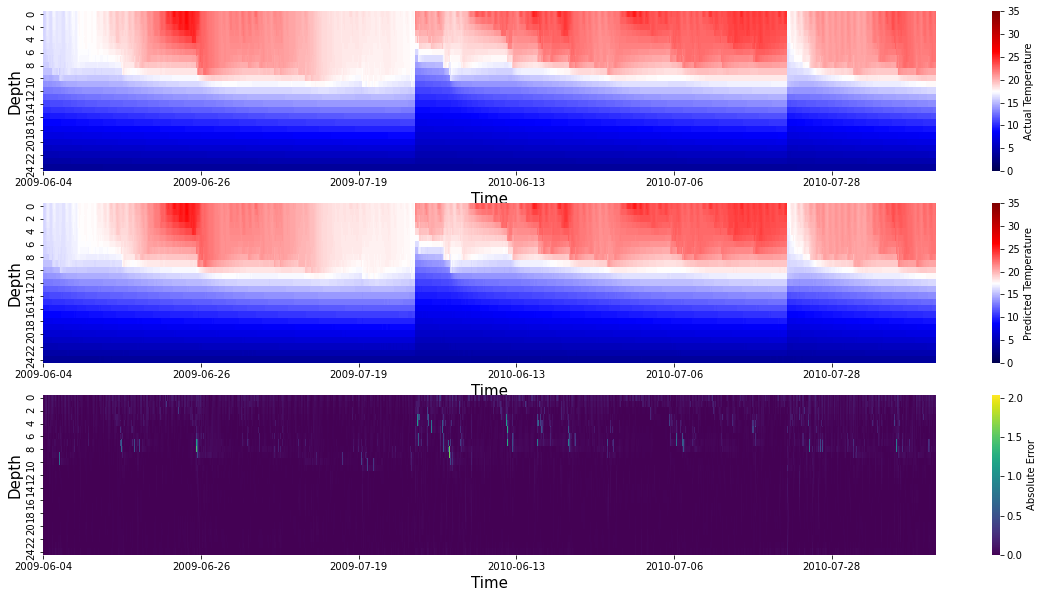

In [78]:
plot_output(train_y_pred, train_y_true, depth_steps, train_time, figsize=(20,10))

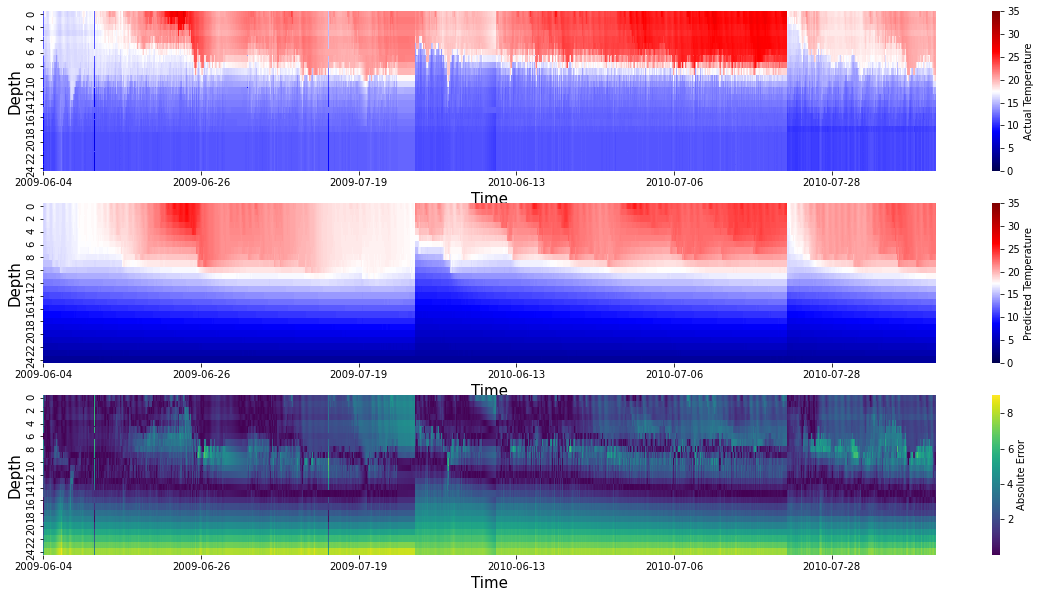

In [79]:
plot_output(train_y_pred, train_y_obs, depth_steps, train_time, figsize=(20,10))

## Test Results

In [80]:
test_y_pred, test_y_true, test_y_obs, test_rmse_models = get_rollout_predictions(heating_model,heat_diff_model, mixing_model, convection_model, ice_model, test_loader, plot = True)

test_rmse = rmse(test_y_pred.flatten(), test_y_true.flatten())
test_rmse_obs = rmse(test_y_pred.flatten(), test_y_obs.flatten())
test_l2 = l2_error(test_y_pred.flatten(), test_y_true.flatten())

print(f"Test RMSE Simulated: {test_rmse}")
print(f"Test RMSE Observed Temp: {test_rmse_obs}")
print(f"test L2 Error: {test_l2}")
print(f"The RMSEs after each modelling stage: {test_rmse_models.mean(axis=0)}")

RMSE of after m0 0.0052240295
tensor([[-2.0051],
        [-1.9272],
        [-1.8776],
        [-1.8553],
        [-1.8525],
        [-1.8459],
        [-1.8220],
        [-1.7975],
        [-1.7878],
        [-1.7982],
        [-1.8124],
        [-1.8208],
        [-1.8213],
        [-1.8188],
        [-1.8169],
        [-1.8161],
        [-1.8161],
        [-1.8165],
        [-1.8173],
        [-1.8184],
        [-1.8198],
        [-1.8212],
        [-1.8217],
        [-1.8199],
        [-1.8198],
        [-2.0027],
        [-1.9236],
        [-1.8736],
        [-1.8541],
        [-1.8515],
        [-1.8448],
        [-1.8228],
        [-1.7977],
        [-1.7880],
        [-1.7981],
        [-1.8123],
        [-1.8207],
        [-1.8214],
        [-1.8189],
        [-1.8171],
        [-1.8163],
        [-1.8162],
        [-1.8165],
        [-1.8173],
        [-1.8185],
        [-1.8199],
        [-1.8213],
        [-1.8218],
        [-1.8199],
        [-1.8198],
        [-1.9958],
 

tensor([[ 1.6389e+00],
        [ 1.6388e+00],
        [ 1.6392e+00],
        [ 1.6399e+00],
        [ 1.6336e+00],
        [ 1.6097e+00],
        [ 1.5824e+00],
        [ 1.5349e+00],
        [ 1.4203e+00],
        [ 1.2079e+00],
        [ 9.4739e-01],
        [ 6.8277e-01],
        [ 4.3388e-01],
        [ 2.0544e-01],
        [-4.3955e-03],
        [-1.9928e-01],
        [-3.8265e-01],
        [-5.5699e-01],
        [-7.2386e-01],
        [-8.8446e-01],
        [-1.0401e+00],
        [-1.1925e+00],
        [-1.3431e+00],
        [-1.4933e+00],
        [-1.6437e+00],
        [ 1.6291e+00],
        [ 1.6294e+00],
        [ 1.6294e+00],
        [ 1.6301e+00],
        [ 1.6310e+00],
        [ 1.6097e+00],
        [ 1.5819e+00],
        [ 1.5333e+00],
        [ 1.4185e+00],
        [ 1.2073e+00],
        [ 9.4781e-01],
        [ 6.8358e-01],
        [ 4.3463e-01],
        [ 2.0593e-01],
        [-4.1438e-03],
        [-1.9908e-01],
        [-3.8234e-01],
        [-5.5660e-01],
        [-7

tensor([[-1.7367],
        [-1.8101],
        [-1.8164],
        [-1.8193],
        [-1.8046],
        [-1.7981],
        [-1.7988],
        [-1.7834],
        [-1.8032],
        [-1.8119],
        [-1.8175],
        [-1.8200],
        [-1.8200],
        [-1.8192],
        [-1.8185],
        [-1.8183],
        [-1.8183],
        [-1.8186],
        [-1.8190],
        [-1.8196],
        [-1.8205],
        [-1.8214],
        [-1.8215],
        [-1.8198],
        [-1.8200],
        [-1.7151],
        [-1.8074],
        [-1.8157],
        [-1.8176],
        [-1.8010],
        [-1.7968],
        [-1.7984],
        [-1.7869],
        [-1.8061],
        [-1.8147],
        [-1.8198],
        [-1.8215],
        [-1.8208],
        [-1.8194],
        [-1.8182],
        [-1.8175],
        [-1.8172],
        [-1.8172],
        [-1.8175],
        [-1.8182],
        [-1.8192],
        [-1.8205],
        [-1.8209],
        [-1.8199],
        [-1.8202],
        [-1.7068],
        [-1.8112],
        [-1.

tensor([[-1.9903],
        [-1.9173],
        [-1.8733],
        [-1.8554],
        [-1.8439],
        [-1.8215],
        [-1.8099],
        [-1.7402],
        [-1.7561],
        [-1.7780],
        [-1.7912],
        [-1.7968],
        [-1.7997],
        [-1.8032],
        [-1.8075],
        [-1.8117],
        [-1.8155],
        [-1.8188],
        [-1.8218],
        [-1.8244],
        [-1.8268],
        [-1.8288],
        [-1.8295],
        [-1.8240],
        [-1.8248],
        [-1.9880],
        [-1.9137],
        [-1.8716],
        [-1.8543],
        [-1.8413],
        [-1.8160],
        [-1.8016],
        [-1.7365],
        [-1.7566],
        [-1.7785],
        [-1.7919],
        [-1.7988],
        [-1.8030],
        [-1.8073],
        [-1.8119],
        [-1.8161],
        [-1.8196],
        [-1.8226],
        [-1.8252],
        [-1.8276],
        [-1.8296],
        [-1.8311],
        [-1.8310],
        [-1.8237],
        [-1.8251],
        [-1.9919],
        [-1.9181],
        [-1.

tensor([[ 1.0055],
        [ 0.9877],
        [ 0.9588],
        [ 0.9331],
        [ 0.8996],
        [ 0.8529],
        [ 0.8005],
        [ 0.7423],
        [ 0.6756],
        [ 0.5959],
        [ 0.4981],
        [ 0.3785],
        [ 0.2373],
        [ 0.0790],
        [-0.0894],
        [-0.2609],
        [-0.4304],
        [-0.5951],
        [-0.7538],
        [-0.9064],
        [-1.0538],
        [-1.1967],
        [-1.3363],
        [-1.4735],
        [-1.6084],
        [ 1.0391],
        [ 1.0108],
        [ 0.9737],
        [ 0.9417],
        [ 0.9045],
        [ 0.8560],
        [ 0.8023],
        [ 0.7433],
        [ 0.6760],
        [ 0.5959],
        [ 0.4980],
        [ 0.3784],
        [ 0.2373],
        [ 0.0790],
        [-0.0894],
        [-0.2610],
        [-0.4306],
        [-0.5954],
        [-0.7543],
        [-0.9070],
        [-1.0544],
        [-1.1974],
        [-1.3368],
        [-1.4737],
        [-1.6083],
        [ 1.0719],
        [ 1.0330],
        [ 0.

tensor([[-2.0595],
        [-1.9953],
        [-1.9304],
        [-1.8903],
        [-1.8706],
        [-1.8605],
        [-1.8530],
        [-1.8487],
        [-1.8082],
        [-1.8089],
        [-1.8178],
        [-1.8275],
        [-1.8325],
        [-1.8314],
        [-1.8274],
        [-1.8233],
        [-1.8200],
        [-1.8178],
        [-1.8168],
        [-1.8170],
        [-1.8181],
        [-1.8196],
        [-1.8206],
        [-1.8189],
        [-1.8217],
        [-2.0606],
        [-1.9880],
        [-1.9238],
        [-1.8872],
        [-1.8865],
        [-1.8501],
        [-1.8543],
        [-1.8440],
        [-1.8025],
        [-1.8038],
        [-1.8146],
        [-1.8264],
        [-1.8330],
        [-1.8329],
        [-1.8293],
        [-1.8249],
        [-1.8211],
        [-1.8184],
        [-1.8168],
        [-1.8166],
        [-1.8174],
        [-1.8188],
        [-1.8198],
        [-1.8182],
        [-1.8206],
        [-2.0422],
        [-1.9711],
        [-1.

tensor([[ 1.1729],
        [ 1.1733],
        [ 1.1732],
        [ 1.1738],
        [ 1.1746],
        [ 1.1710],
        [ 1.1661],
        [ 1.1612],
        [ 1.1622],
        [ 1.1524],
        [ 0.9461],
        [ 0.7650],
        [ 0.5677],
        [ 0.3503],
        [ 0.1280],
        [-0.0858],
        [-0.2857],
        [-0.4721],
        [-0.6477],
        [-0.8155],
        [-0.9779],
        [-1.1368],
        [-1.2935],
        [-1.4490],
        [-1.6042],
        [ 1.1652],
        [ 1.1653],
        [ 1.1647],
        [ 1.1648],
        [ 1.1650],
        [ 1.1654],
        [ 1.1642],
        [ 1.1620],
        [ 1.1631],
        [ 1.1461],
        [ 0.9458],
        [ 0.7640],
        [ 0.5676],
        [ 0.3516],
        [ 0.1300],
        [-0.0842],
        [-0.2847],
        [-0.4714],
        [-0.6470],
        [-0.8145],
        [-0.9767],
        [-1.1355],
        [-1.2925],
        [-1.4486],
        [-1.6044],
        [ 1.1540],
        [ 1.1554],
        [ 1.

tensor([[-2.0705],
        [-1.8757],
        [-1.8899],
        [-1.8669],
        [-1.8496],
        [-1.8331],
        [-1.8155],
        [-1.7982],
        [-1.7860],
        [-1.7823],
        [-1.7865],
        [-1.7955],
        [-1.8054],
        [-1.8130],
        [-1.8168],
        [-1.8170],
        [-1.8149],
        [-1.8121],
        [-1.8100],
        [-1.8091],
        [-1.8095],
        [-1.8109],
        [-1.8117],
        [-1.8083],
        [-1.8128],
        [-2.0307],
        [-1.8568],
        [-1.8876],
        [-1.8676],
        [-1.8515],
        [-1.8365],
        [-1.8204],
        [-1.8049],
        [-1.7947],
        [-1.7920],
        [-1.7958],
        [-1.8030],
        [-1.8101],
        [-1.8145],
        [-1.8155],
        [-1.8136],
        [-1.8103],
        [-1.8073],
        [-1.8055],
        [-1.8053],
        [-1.8065],
        [-1.8083],
        [-1.8094],
        [-1.8057],
        [-1.8105],
        [-2.0251],
        [-1.9959],
        [-1.

tensor([[-1.7021],
        [-1.8042],
        [-1.8189],
        [-1.7908],
        [-1.8140],
        [-1.8153],
        [-1.8036],
        [-1.7938],
        [-1.8036],
        [-1.8135],
        [-1.8137],
        [-1.8140],
        [-1.8165],
        [-1.8188],
        [-1.8198],
        [-1.8195],
        [-1.8185],
        [-1.8172],
        [-1.8164],
        [-1.8164],
        [-1.8174],
        [-1.8191],
        [-1.8205],
        [-1.8195],
        [-1.8222],
        [-1.7175],
        [-1.8124],
        [-1.8222],
        [-1.7928],
        [-1.8146],
        [-1.8168],
        [-1.8054],
        [-1.7951],
        [-1.8039],
        [-1.8140],
        [-1.8145],
        [-1.8146],
        [-1.8167],
        [-1.8187],
        [-1.8195],
        [-1.8191],
        [-1.8180],
        [-1.8167],
        [-1.8159],
        [-1.8160],
        [-1.8170],
        [-1.8188],
        [-1.8203],
        [-1.8193],
        [-1.8220],
        [-1.7597],
        [-1.8278],
        [-1.

RMSE of after m0 0.022882352
tensor([[-1.7801],
        [-1.8187],
        [-1.8105],
        [-1.8199],
        [-1.8273],
        [-1.8217],
        [-1.8071],
        [-1.7935],
        [-1.7910],
        [-1.7983],
        [-1.8085],
        [-1.8160],
        [-1.8198],
        [-1.8213],
        [-1.8220],
        [-1.8221],
        [-1.8217],
        [-1.8210],
        [-1.8204],
        [-1.8204],
        [-1.8210],
        [-1.8221],
        [-1.8226],
        [-1.8197],
        [-1.8227],
        [-1.7278],
        [-1.8101],
        [-1.8073],
        [-1.8156],
        [-1.8242],
        [-1.8203],
        [-1.8074],
        [-1.7955],
        [-1.7935],
        [-1.8008],
        [-1.8108],
        [-1.8182],
        [-1.8217],
        [-1.8230],
        [-1.8231],
        [-1.8223],
        [-1.8211],
        [-1.8198],
        [-1.8190],
        [-1.8192],
        [-1.8205],
        [-1.8224],
        [-1.8237],
        [-1.8206],
        [-1.8251],
        [-1.7167],
  

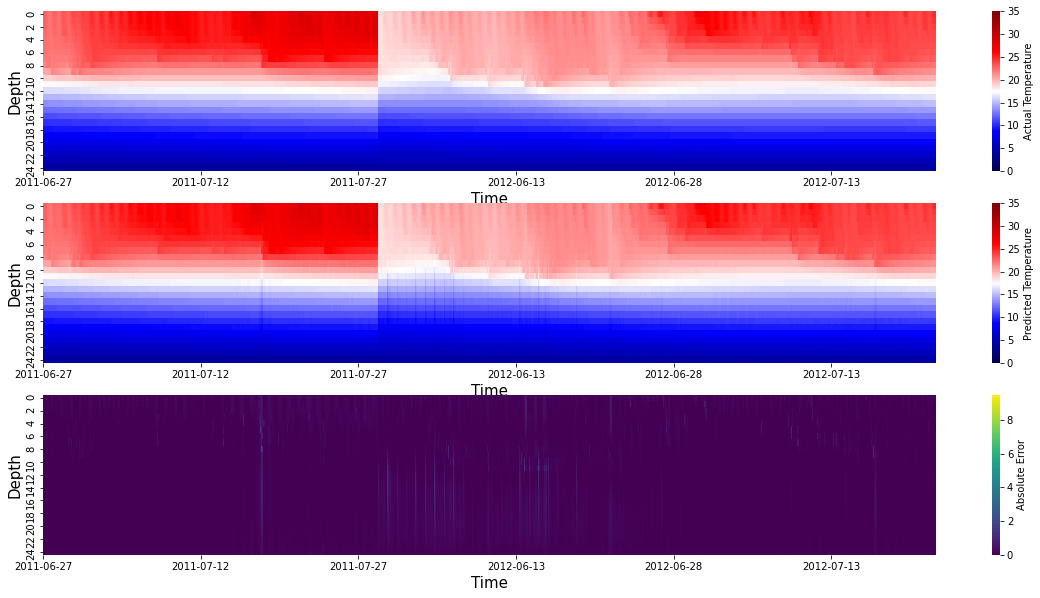

In [81]:
plot_output(test_y_pred, test_y_true, depth_steps, test_time, figsize=(20,10))

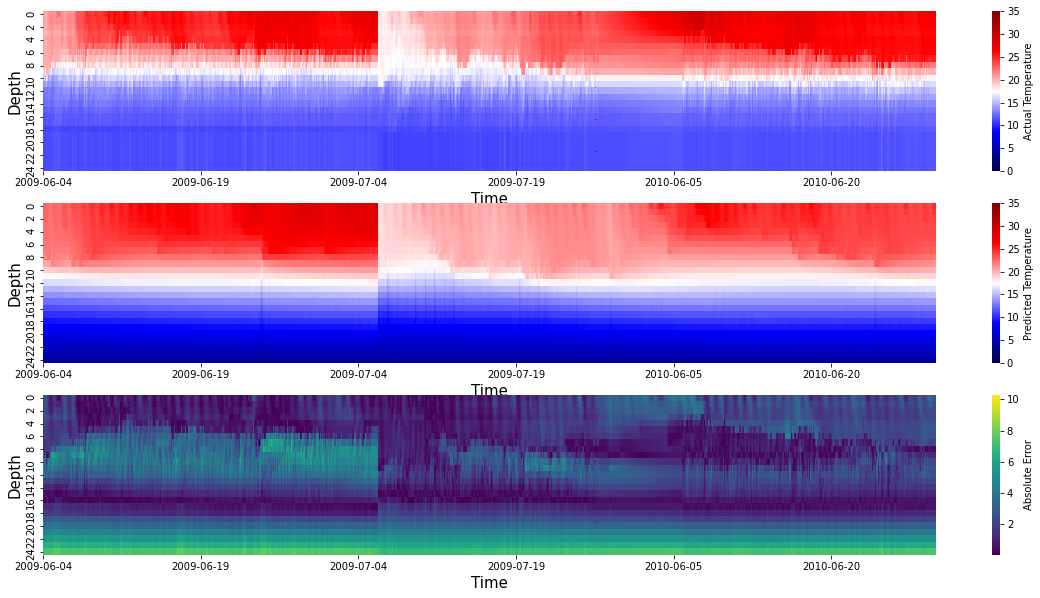

In [82]:
plot_output(test_y_pred, test_y_obs, depth_steps, train_time, figsize=(20,10))

# Evaluate ALL Models individually

## Heat Diffusion Model

In [83]:
train_rmse, train_l2_err = compute_metrics( heat_diff_model, train_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(heat_diff_model, test_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 12.827437599999891, Train L2 Error: 0.8309701714641251
Test RMSE: 14.88900707541003, Train L2 Error: 0.8487842305478619


## Mixing Model

In [84]:
train_rmse, train_l2_err = compute_metrics(mixing_model, train_loader, m2_input_column_ix, m2_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(mixing_model, test_loader, m2_input_column_ix, m2_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.0435148034361539, Train L2 Error: 0.0028188573841423452
Test RMSE: 0.04440403271307789, Train L2 Error: 0.0025312998691790854


## Convection Model

In [85]:
train_rmse, train_l2_err = compute_metrics(convection_model, train_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(convection_model, test_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.006609912617224429, Train L2 Error: 0.00042818981247232937
Test RMSE: 0.011185664355474322, Train L2 Error: 0.0006376559065977617


## Ice Model

In [86]:
train_rmse, train_l2_err = compute_metrics(ice_model, train_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(ice_model, test_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.0008162126385603805, Train L2 Error: 5.287421436283234e-05
Test RMSE: 0.005814208886940472, Train L2 Error: 0.00033144787123317687


# Finetuning

In [87]:
lr = 1e-5
# decay_rate = 0.1
# decay_steps = 500

params = list(heating_model.parameters()) + list(heat_diff_model.parameters()) + list(mixing_model.parameters()) + list(convection_model.parameters()) + list(ice_model.parameters())

optimizer = torch.optim.Adam(params, lr=lr, 
                             betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=decay_steps, gamma=decay_rate)

criterion = torch.nn.MSELoss()

# Freeze model weights

In [88]:
def freeze_model(model):
    for param in model.parameters():
        param.requires_grad = False

def unfreeze_model(model):
    for param in model.parameters():
        param.requires_grad = True

In [89]:
freeze_model(heating_model)
freeze_model(mixing_model)
freeze_model(convection_model)
freeze_model(ice_model)
unfreeze_model(heat_diff_model)
#unfreeze_model(heating_model)

# Finetuning on Observed Temperature

In [ ]:
heating_model.train()
heat_diff_model.train()
mixing_model.train()
convection_model.train()
ice_model.train()

n_epochs = 500

# mean and standard dev of "temp_total04" of model 4 output
mean_out4 = torch.tensor(train_mean[m4_output_column_ix[0]]).float().to(device)
std_out4 = torch.tensor(train_std[m4_output_column_ix[0]]).float().to(device)

mean_obs = torch.tensor(train_mean[obs_temp_columns_ix[0]]).float().to(device)
std_obs = torch.tensor(train_std[obs_temp_columns_ix[0]]).float().to(device)

# mean and standard dev of "input_temp" of model 1 input
m1_mean = torch.tensor(train_mean[m1_input_column_ix[-1]]).float().to(device)
m1_std = torch.tensor(train_std[m1_input_column_ix[-1]]).float().to(device)

train_loss = []
LOSS_m0 = []
LOSS_m1 = []
LOSS_m2 = []
LOSS_m3 = []
LOSS_m4 = []

for it in tqdm(range(n_epochs)):
    loss_epoch = 0
    loss_epoch_m0 = 0
    loss_epoch_m1 = 0
    loss_epoch_m2 = 0
    loss_epoch_m3 = 0
    loss_epoch_m4 = 0
    for ix, x in enumerate(iter(train_loader)):
        x = x.to(device).float()
        optimizer.zero_grad()
        
      #  m1_input = x[:, m1_input_column_ix]
        m0_input = x[:, m0_input_column_ix]
        
        #model 0
        m0_pred = heating_model(m0_input) #predicts diff and temp
        loss_m0 = criterion(m0_pred, x[:, m0_output_column_ix])

        #model 1
        m1_input = torch.cat([x[:, m1_input_column_ix[:-1]], m0_pred], dim=-1)
        # m1_pred = heat_diff_model(m1_input)
        
        proj = heat_diff_model(m1_input)
        
        print (proj)
        
        pred = implicit_diffusion(proj, m0_pred)        
        m1_pred = pred.to(dtype=torch.float32)
                
        print(m1_pred)
        
        loss_m1 = criterion(m1_pred, x[:, m1_output_column_ix])
        
        #m1_pred = heat_diff_model(m1_input) #predicts diff and temp
        #m1_pred_temp = m1_pred[:,1:2]
            
        #loss_m1 = criterion(m1_pred_temp, x[:, m1_output_column_ix[1]].unsqueeze(1))

        #model 2
        m2_input = torch.cat([x[:, m2_input_column_ix[:-1]], m1_pred], dim=-1)
        m2_pred = mixing_model(m2_input)
            
        loss_m2 = criterion(m2_pred, x[:, m2_output_column_ix])

        #model 3
        m3_input = torch.cat([x[:, m3_input_column_ix[:-1]], m2_pred], dim=-1)
        m3_pred = convection_model(m3_input)

        loss_m3 = criterion(m3_pred, x[:, m3_output_column_ix])

        #model 4
        m4_input = torch.cat([x[:, m4_input_column_ix[:-1]], m3_pred], dim=-1)
        m4_pred = ice_model(m4_input)
        
        obs_temp_true = x[:, obs_temp_columns_ix] * std_obs + mean_obs
        obs_temp_true_norm = (obs_temp_true - mean_out4)/std_out4
        
        loss_m4 = criterion(m4_pred, obs_temp_true_norm)

        #loss = (loss_m0 + loss_m1 + loss_m2 + loss_m3 + loss_m4)
        
        loss = loss_m4
        
        loss.backward()
        optimizer.step()
        
        loss_epoch += loss.item()
        loss_epoch_m0 += loss_m0.item()
        loss_epoch_m1 += loss_m1.item()
        loss_epoch_m2 += loss_m2.item()
        loss_epoch_m3 += loss_m3.item()
        loss_epoch_m4 += loss_m4.item()
    
    loss_epoch = loss_epoch/len(train_loader)
    loss_epoch_m0 = loss_epoch_m0/len(train_loader)
    loss_epoch_m1 = loss_epoch_m1/len(train_loader)
    loss_epoch_m2 = loss_epoch_m2/len(train_loader)
    loss_epoch_m3 = loss_epoch_m3/len(train_loader)
    loss_epoch_m4 = loss_epoch_m4/len(train_loader)
    
    train_loss.append(loss_epoch)
    LOSS_m0.append(loss_epoch_m0)
    LOSS_m1.append(loss_epoch_m1)
    LOSS_m2.append(loss_epoch_m2)
    LOSS_m3.append(loss_epoch_m3)
    LOSS_m4.append(loss_epoch_m4)
    if it % 50 == 0:
        print(f"Epoch : {it}, Train_loss: {train_loss[-1]}, Loss m0: {LOSS_m0[-1]}, Loss m1: {LOSS_m1[-1]}, Loss m2: {LOSS_m2[-1]}, Loss m3: {LOSS_m3[-1]}, Loss m4: {LOSS_m4[-1]}")
    
    #plot the loss_m1, m2


  0%|          | 1/500 [00:00<06:14,  1.33it/s]

Epoch : 0, Train_loss: 0.3029380817623699, Loss m0: 4.997979521490111e-06, Loss m1: 2.5403267361124404e-05, Loss m2: 6.720240722001216e-05, Loss m3: 6.633828627266612e-05, Loss m4: 0.3029380817623699


  7%|▋         | 35/500 [00:27<06:06,  1.27it/s]

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(train_loss, label = "Train Loss")
plt.plot(LOSS_m0, label = "Loss M0")
plt.plot(LOSS_m1, label = "Loss M1")
plt.plot(LOSS_m2, label = "Loss M2")
plt.plot(LOSS_m3, label = "Loss M3")
plt.plot(LOSS_m4, label = "Loss M4")
plt.ylabel("Loss", fontsize=15)
plt.xlabel("Epoch", fontsize=15)
plt.yscale("log")
plt.legend(fontsize=15)
plt.show()

# Rollout Evaluation After FineTuning

In [ ]:
train_y_pred, train_y_true, train_y_obs, train_rmse_models = get_rollout_predictions(heating_model, heat_diff_model, mixing_model, convection_model, ice_model, train_loader, plot = True)

train_rmse = rmse(train_y_pred.flatten(), train_y_true.flatten())
train_rmse_obs = rmse(train_y_pred.flatten(), train_y_obs.flatten())
train_l2 = l2_error(train_y_pred.flatten(), train_y_true.flatten())

print(f"Train RMSE Simulated: {train_rmse}")
print(f"Train RMSE Observed Temp: {train_rmse_obs}")
print(f"Train L2 Error: {train_l2}")
print(f"The RMSEs after each modelling stage: {train_rmse_models.mean(axis=0)}")

In [ ]:
plot_output(train_y_pred, train_y_true, depth_steps, train_time, figsize=(20,10))

In [ ]:
plot_output(train_y_pred, train_y_obs, depth_steps, train_time, figsize=(20,10))

In [ ]:
test_y_pred, test_y_true, test_y_obs, test_rmse_models = get_rollout_predictions(heating_model, heat_diff_model, mixing_model, convection_model, ice_model, test_loader, plot = True)

test_rmse = rmse(test_y_pred.flatten(), test_y_true.flatten())
test_rmse_obs = rmse(test_y_pred.flatten(), test_y_obs.flatten())
test_l2 = l2_error(test_y_pred.flatten(), test_y_true.flatten())

print(f"Test RMSE Simulated: {test_rmse}")
print(f"Test RMSE Observed Temp: {test_rmse_obs}")
print(f"test L2 Error: {test_l2}")
print(f"The RMSEs after each modelling stage: {test_rmse_models.mean(axis=0)}")

In [ ]:
plot_output(test_y_pred, test_y_true, depth_steps, test_time, figsize=(20,10))

In [ ]:
plot_output(test_y_pred, test_y_obs, depth_steps, train_time, figsize=(20,10))

# Evaluate ALL Models individually

## Heat Diffusion Model

In [ ]:
train_rmse, train_l2_err = compute_metrics(heat_diff_model, train_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(heat_diff_model, test_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

## Mixing Model

In [ ]:
train_rmse, train_l2_err = compute_metrics(mixing_model, train_loader, m2_input_column_ix, m2_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(mixing_model, test_loader, m2_input_column_ix, m2_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

## Convection Model

In [ ]:
train_rmse, train_l2_err = compute_metrics(convection_model, train_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(convection_model, test_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

## Ice Model

In [ ]:
train_rmse, train_l2_err = compute_metrics(ice_model, train_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(ice_model, test_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

# Compute Model Similarity after Finetuning

In [ ]:
def compute_model_similarity(model1, model2):
    weight1 = []
    weight2 = []
    for param1, param2 in zip(model1.parameters(), model2.parameters()):
        weight1.append(param1.detach().clone().flatten())
        weight2.append(param2.detach().clone().flatten())
    weight1 = torch.cat(weight1, dim=0)
    weight2 = torch.cat(weight2, dim=0)
    
    #Cosine Similarity
    cos = nn.CosineSimilarity(dim=0, eps=1e-8)
    cos_sim = cos(weight1, weight2)
    
    #L2 norm
    l2 = torch.norm((weight1-weight2), p='fro', dim=0)
    
    return cos_sim, l2

In [ ]:
heat_diff_model_init = MLP(m1_layers, activation="gelu")
heat_diff_model_init.load_state_dict(m1_checkpoint)
heat_diff_model_init = heat_diff_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(heat_diff_model_init, heat_diff_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

In [ ]:
mixing_model_init = MLP(m2_layers, activation="gelu")
mixing_model_init.load_state_dict(m2_checkpoint)
mixing_model_init = mixing_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(mixing_model_init, mixing_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

In [ ]:
convection_model_init = MLP(m3_layers, activation="gelu")
convection_model_init.load_state_dict(m3_checkpoint)
convection_model_init = convection_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(convection_model_init, convection_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

In [ ]:
ice_model_init = MLP(m4_layers, activation="gelu")
ice_model_init.load_state_dict(m4_checkpoint)
ice_model_init = ice_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(ice_model_init, ice_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")